In [1]:
%matplotlib notebook
import numpy as np
import operator
import scipy
import math
import scipy.ndimage
import matplotlib.patches
from scipy.spatial import distance
import photutils
import itertools
from photutils import centroid_com
from scipy import ndimage
from scipy import optimize
from scipy.optimize import least_squares
import h5py
import matplotlib
import matplotlib.pyplot as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter
import cv2
from scipy.ndimage.morphology import binary_fill_holes
import os, re
import sys
import skimage
from skimage import morphology
sourcepath = '/Users/niloo/Desktop/SwissFel_2019/data_beamtime/SwissFEL_BERNINA_20181820-master/src'
sys.path.insert(0, sourcepath)
import calibrators
from calibrators import *
import xlsxwriter
import pandas as pd

In [2]:
# for specific shot and run number read the information in the HDF files
'''DISTANCE SHOULD BE SAVED PER PEAK TO SET THE THRESHOLD FOR MINIMUM DISTANCE TO OTHER PEAKS 
   SO THAT WE GET ONE MIN_Q AND JUDGE THE DISTANCE TO OTHER PEAKS TO SEE IF THEY CAN BE SINGLE OR MULTIPLE PEAKS'''
def specific_shots(run, shot, path=None):
    '''
    open specific shots in a run and load its keys,
    '''
    peak_list = []
    center_mass = []
    radius = []
    q_cm = []
    min_distance = []
    distances = []
    h5path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    h5file = h5py.File(h5path,'r')
    n_peaks = h5file['shots'][shot]['numberOfPeaks'][()]
    if n_peaks >= 1:
        qcm_x = h5file['shots'][shot]['peakCenterOfMassQx'][()]
        qcm_y = h5file['shots'][shot]['peakCenterOfMassQy'][()]
        q_tot = list(zip(qcm_x,qcm_y))
        for i in range(n_peaks):
            peak_list.append(h5file['shots'][shot]['peak%d'%i]['diffraction'][:])
            center_mass.append(h5file['shots'][shot]['peak%d'%i]['centerOfMassInPixels'][:])
            radius.append(h5file['shots'][shot]['peak%d'%i]['radiusInPixels'][()])
            q_cm.append(h5file['shots'][shot]['peak%d'%i]['peakCenterOfMassQMagnitude'][:])
            qx_peak = h5file['shots'][shot]['peak%d'%i]['peakCenterOfMassQx'][()]
            qy_peak = h5file['shots'][shot]['peak%d'%i]['peakCenterOfMassQy'][()]
            q_peak = list(zip(qx_peak,qy_peak))
            d = distance.cdist(q_peak,q_tot)
            all_dist = d[np.nonzero(d)]
            distances.append(np.array(all_dist).flatten())
            try:
                min_dist = np.min(d[np.nonzero(d)])
                min_distance.append(min_dist)
            except:
                pass
    h5file.close()
    return  {'peaks': peak_list,
             'center_mass': center_mass,
             'min_distance': min_distance,
             'distances': distances,
             'q_cm': q_cm,
             'No_of_peaks': n_peaks,
             'radiusInPixels': radius}

In [3]:
# binsize = 0.1 or 0.2
def downsample(x, y, size=int(2)):
    assert (len(x) == len(y))
    if (len(x)%size != 0):
        print('WARNING: size of %d in input arrays are not dividable with %d, remainder: %d' % (len(x), size, len(x)%size))
    n = np.int(np.ceil(len(x)/size))
    new_x = np.zeros(n)
    new_y = np.zeros(n)
    for i in range(n):
        new_x[i] = np.average(x[i*size:(i+1)*size])
        new_y[i] = np.sum(y[i*size:(i+1)*size])
    return new_x, new_y

In [4]:
# read nested dictionary and take out the values
def d_values(d, depth):
    if depth == 1:
        for i in d.values():
            yield i
    else:
        for v in d.values():
            if isinstance(v, dict):
                for i in d_values(v, depth-1):
                    yield i

In [5]:
# create nested dictionary
def create_dict_levels(Dict, run, shot, peak, region=None):
    try:
        d = Dict[run]
    except KeyError:
        Dict[run] = {}
    try:
        d = Dict[run][shot]
    except KeyError:
        Dict[run][shot] = {}
    try:
        d = Dict[run][shot]['peak%d'%peak]
    except KeyError:
        Dict[run][shot]['peak%d'%peak] = {}
    try:
        if region is not None:
            d = Dict[run][shot]['peak%d'%peak]['region%d'%region]
    except KeyError:
        Dict[run][shot]['peak%d'%peak]['region%d'%region] = {}
    return Dict

def Shot_for_sp(T_group, shots, area_thr = 10, choice = 'large_peaks', n_Max = None, lower_qcm= 0, upper_qcm = 8, lower_sphericity =0, upper_sphericity=1.1, minimum_d = None, maximum_d = None, I_min = -1, I_max = 1.1):
    Dict = {}
    for n, run in enumerate(T_group):
        for shot in shots[run]:
            min_d = specific_shots(run, shot)['min_distance']
            all_d = specific_shots(run, shot)['distances']
            p_n = specific_shots(run, shot)['peaks']
            q_cm = specific_shots(run, shot)['q_cm']
            for peak_i in np.arange(len(p_n)):
                p_n[peak_i][np.where(p_n[peak_i] < 0)] = 0
                blur = skimage.filters.gaussian(p_n[peak_i], sigma=1)
                t_log = skimage.filters.threshold_otsu(np.nan_to_num(np.log(blur)))
                t = skimage.filters.threshold_otsu(blur)
                p_mask = blur > t
                p_mask_log = np.nan_to_num(np.log(blur)) > t_log
                fill_holes = binary_fill_holes(p_mask)
                fill_holes_log = binary_fill_holes(p_mask_log)
                labeled_image, number_of_peaks = scipy.ndimage.label(fill_holes.astype(np.float32))
                labeled_image_log, number_of_peaks_log = scipy.ndimage.label(fill_holes_log.astype(np.float32))
                peak_regions = scipy.ndimage.find_objects(labeled_image)
                peak_regions_log = scipy.ndimage.find_objects(labeled_image_log)
                contours,_= cv2.findContours(fill_holes.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                contours_log,_= cv2.findContours(fill_holes_log.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                lst_intensities = []
                lst_intensities_log = []
                for cnt in range(len(contours)):
                    cimg = np.zeros_like(p_n[peak_i])
                    cv2.drawContours(cimg, contours, cnt, color=255, thickness=-1)
                    # Access the image pixels and create a 1D numpy array then add to list
                    pts = np.where(cimg == 255)
                    lst_intensities.append(p_n[peak_i][pts].sum())
                local_maxima = len(lst_intensities)
                rel_intens = np.array([lst_intensities[z]/p_n[peak_i].sum() for z in range(len(lst_intensities))])
                desired_peak_inx = np.argmax(lst_intensities)
                perimeter = cv2.arcLength(contours[desired_peak_inx], True)
                area = cv2.contourArea(contours[desired_peak_inx])
                if perimeter != 0:
                    sphericity =4*np.pi*area/(perimeter**2)
                else:
                    sphericity = None
                for cnt_l in range(len(contours_log)):
                    cimg_log = np.zeros_like(p_n[peak_i])
                    cv2.drawContours(cimg_log, contours_log, cnt_l, color=255, thickness=-1)
                    # Access the image pixels and create a 1D numpy array then add to list
                    pts_log = np.where(cimg_log == 255)
                    lst_intensities_log.append(p_n[peak_i][pts_log].sum())
                local_maxima_log = len(lst_intensities_log)
                rel_intens_log = np.array([lst_intensities_log[z]/p_n[peak_i].sum() for z in range(len(lst_intensities_log))])
                desired_peak_inx_log = np.argmax(rel_intens_log)
                perimeter_log = cv2.arcLength(contours_log[desired_peak_inx_log], True)
                area_log = cv2.contourArea(contours_log[desired_peak_inx_log])
                if perimeter_log != 0:
                    sphericity_log =4*np.pi*area_log/(perimeter_log**2)
                else:
                    sphericity_log = None 
                if (choice == 'large_peaks') & (sphericity is not None) & (area >= area_thr):
                    if (minimum_d is not None) & (maximum_d is not None) & (len(min_d)!=0):
                        if ((q_cm[peak_i] >= lower_qcm) & (q_cm[peak_i] < upper_qcm)) & ((sphericity >= lower_sphericity) & (sphericity < upper_sphericity)) & ((min_d[peak_i] >= minimum_d) & (min_d[peak_i] < maximum_d)) & ((rel_intens[desired_peak_inx] >= I_min) & (rel_intens[desired_peak_inx] < I_max)):
                            if n_Max is None:
                                Dict = create_dict_levels(Dict, run, shot, peak_i)
                                Dict[run][shot]['peak%d'%peak_i]['q_cm'] = q_cm[peak_i]
                                Dict[run][shot]['peak%d'%peak_i]['Otsu_sphericity'] = sphericity
                                Dict[run][shot]['peak%d'%peak_i]['Otsu_area'] = area
                                Dict[run][shot]['peak%d'%peak_i]['Otsu_perimeter'] = perimeter
                                Dict[run][shot]['peak%d'%peak_i]['Otsu_max_intensity'] = rel_intens[desired_peak_inx]
                                Dict[run][shot]['peak%d'%peak_i]['Otsu_Number_of_maxima'] = local_maxima
                                Dict[run][shot]['peak%d'%peak_i]['log-Otsu_sphericity'] = sphericity_log
                                Dict[run][shot]['peak%d'%peak_i]['log-Otsu_area'] = area_log
                                Dict[run][shot]['peak%d'%peak_i]['log-Otsu_perimeter'] = perimeter_log
                                Dict[run][shot]['peak%d'%peak_i]['log-Otsu_max_intensity'] = rel_intens_log[desired_peak_inx_log]
                                Dict[run][shot]['peak%d'%peak_i]['log-Otsu_Number_of_maxima'] = local_maxima_log
                                Dict[run][shot]['peak%d'%peak_i]['all_distances'] = [all_d[peak_i] if len(p_n)!=1 else []]
                                Dict[run][shot]['peak%d'%peak_i]['min_distance'] = [min_d[peak_i] if len(p_n)!=1 else []]
                            elif n_Max is not None:
                                if local_maxima == n_Max:
                                    Dict = create_dict_levels(Dict, run, shot, peak_i)
                                    Dict[run][shot]['peak%d'%peak_i]['q_cm'] = q_cm[peak_i]
                                    Dict[run][shot]['peak%d'%peak_i]['Otsu_sphericity'] = sphericity
                                    Dict[run][shot]['peak%d'%peak_i]['Otsu_area'] = area
                                    Dict[run][shot]['peak%d'%peak_i]['Otsu_perimeter'] = perimeter
                                    Dict[run][shot]['peak%d'%peak_i]['Otsu_max_intensity'] = rel_intens[desired_peak_inx]
                                    Dict[run][shot]['peak%d'%peak_i]['Otsu_Number_of_maxima'] = local_maxima
                                    Dict[run][shot]['peak%d'%peak_i]['log-Otsu_sphericity'] = sphericity_log
                                    Dict[run][shot]['peak%d'%peak_i]['log-Otsu_area'] = area_log
                                    Dict[run][shot]['peak%d'%peak_i]['log-Otsu_perimeter'] = perimeter_log
                                    Dict[run][shot]['peak%d'%peak_i]['log-Otsu_max_intensity'] = rel_intens_log[desired_peak_inx_log]
                                    Dict[run][shot]['peak%d'%peak_i]['log-Otsu_Number_of_maxima'] = local_maxima_log
                                    Dict[run][shot]['peak%d'%peak_i]['all_distances'] = [all_d[peak_i] if len(p_n)!=1 else []]
                                    Dict[run][shot]['peak%d'%peak_i]['min_distance'] = [min_d[peak_i] if len(p_n)!=1 else []]
                                else:
                                    pass    
                        else:
                            pass
                    elif (minimum_d is None) & (maximum_d is None):
                        if ((q_cm[peak_i] >= lower_qcm) & (q_cm[peak_i] < upper_qcm)) & ((sphericity >= lower_sphericity) & (sphericity < upper_sphericity)) & ((rel_intens[desired_peak_inx] >= I_min) & (rel_intens[desired_peak_inx] < I_max)):
                            if (n_Max is None):
                                Dict = create_dict_levels(Dict, run, shot, peak_i)
                                Dict[run][shot]['peak%d'%peak_i]['q_cm'] = q_cm[peak_i]
                                Dict[run][shot]['peak%d'%peak_i]['Otsu_sphericity'] = sphericity
                                Dict[run][shot]['peak%d'%peak_i]['Otsu_area'] = area
                                Dict[run][shot]['peak%d'%peak_i]['Otsu_perimeter'] = perimeter
                                Dict[run][shot]['peak%d'%peak_i]['Otsu_max_intensity'] = rel_intens[desired_peak_inx]
                                Dict[run][shot]['peak%d'%peak_i]['Otsu_Number_of_maxima'] = local_maxima
                                Dict[run][shot]['peak%d'%peak_i]['log-Otsu_sphericity'] = sphericity_log
                                Dict[run][shot]['peak%d'%peak_i]['log-Otsu_area'] = area_log
                                Dict[run][shot]['peak%d'%peak_i]['log-Otsu_perimeter'] = perimeter_log
                                Dict[run][shot]['peak%d'%peak_i]['log-Otsu_max_intensity'] = rel_intens_log[desired_peak_inx_log]
                                Dict[run][shot]['peak%d'%peak_i]['log-Otsu_Number_of_maxima'] = local_maxima_log
                                Dict[run][shot]['peak%d'%peak_i]['all_distances'] = [all_d[peak_i] if len(p_n)!=1 else []]
                                Dict[run][shot]['peak%d'%peak_i]['min_distance'] = [min_d[peak_i] if len(p_n)!=1 else []]
                            elif n_Max is not None:
                                if local_maxima == n_Max:
                                    Dict = create_dict_levels(Dict, run, shot, peak_i)
                                    Dict[run][shot]['peak%d'%peak_i]['q_cm'] = q_cm[peak_i]
                                    Dict[run][shot]['peak%d'%peak_i]['Otsu_sphericity'] = sphericity
                                    Dict[run][shot]['peak%d'%peak_i]['Otsu_area'] = area
                                    Dict[run][shot]['peak%d'%peak_i]['Otsu_perimeter'] = perimeter
                                    Dict[run][shot]['peak%d'%peak_i]['Otsu_max_intensity'] = rel_intens[desired_peak_inx]
                                    Dict[run][shot]['peak%d'%peak_i]['Otsu_Number_of_maxima'] = local_maxima
                                    Dict[run][shot]['peak%d'%peak_i]['log-Otsu_sphericity'] = sphericity_log
                                    Dict[run][shot]['peak%d'%peak_i]['log-Otsu_area'] = area_log
                                    Dict[run][shot]['peak%d'%peak_i]['log-Otsu_perimeter'] = perimeter_log
                                    Dict[run][shot]['peak%d'%peak_i]['log-Otsu_max_intensity'] = rel_intens_log[desired_peak_inx_log]
                                    Dict[run][shot]['peak%d'%peak_i]['log-Otsu_Number_of_maxima'] = local_maxima_log
                                    Dict[run][shot]['peak%d'%peak_i]['all_distances'] = [all_d[peak_i] if len(p_n)!=1 else []]
                                    Dict[run][shot]['peak%d'%peak_i]['min_distance'] = [min_d[peak_i] if len(p_n)!=1 else []]
                                else:
                                    pass
                        else:
                            pass
                        
                elif (choice == 'small_peaks') & (sphericity is not None) & (area < area_thr):
                    if (minimum_d is not None) & (maximum_d is not None) & (len(min_d)!=0):
                        if ((q_cm[peak_i] >= lower_qcm) & (q_cm[peak_i] < upper_qcm)) & ((sphericity >= lower_sphericity) & (sphericity < upper_sphericity)) & ((min_d[peak_i] >= minimum_d) & (min_d[peak_i] < maximum_d)) & ((rel_intens[desired_peak_inx] >= I_min) & (rel_intens[desired_peak_inx] < I_max)):
                            if n_Max is None:
                                Dict = create_dict_levels(Dict, run, shot, peak_i)
                                Dict[run][shot]['peak%d'%peak_i]['q_cm'] = q_cm[peak_i]
                                Dict[run][shot]['peak%d'%peak_i]['Otsu_sphericity'] = sphericity
                                Dict[run][shot]['peak%d'%peak_i]['Otsu_area'] = area
                                Dict[run][shot]['peak%d'%peak_i]['Otsu_perimeter'] = perimeter
                                Dict[run][shot]['peak%d'%peak_i]['Otsu_max_intensity'] = rel_intens[desired_peak_inx]
                                Dict[run][shot]['peak%d'%peak_i]['Otsu_Number_of_maxima'] = local_maxima
                                Dict[run][shot]['peak%d'%peak_i]['log-Otsu_sphericity'] = sphericity_log
                                Dict[run][shot]['peak%d'%peak_i]['log-Otsu_area'] = area_log
                                Dict[run][shot]['peak%d'%peak_i]['log-Otsu_perimeter'] = perimeter_log
                                Dict[run][shot]['peak%d'%peak_i]['log-Otsu_max_intensity'] = rel_intens_log[desired_peak_inx_log]
                                Dict[run][shot]['peak%d'%peak_i]['log-Otsu_Number_of_maxima'] = local_maxima_log
                                Dict[run][shot]['peak%d'%peak_i]['all_distances'] = [all_d[peak_i] if len(p_n)!=1 else []]
                                Dict[run][shot]['peak%d'%peak_i]['min_distance'] = [min_d[peak_i] if len(p_n)!=1 else []]
                            elif n_Max is not None:
                                if local_maxima == n_Max:
                                    Dict = create_dict_levels(Dict, run, shot, peak_i)
                                    Dict[run][shot]['peak%d'%peak_i]['q_cm'] = q_cm[peak_i]
                                    Dict[run][shot]['peak%d'%peak_i]['Otsu_sphericity'] = sphericity
                                    Dict[run][shot]['peak%d'%peak_i]['Otsu_area'] = area
                                    Dict[run][shot]['peak%d'%peak_i]['Otsu_perimeter'] = perimeter
                                    Dict[run][shot]['peak%d'%peak_i]['Otsu_max_intensity'] = rel_intens[desired_peak_inx]
                                    Dict[run][shot]['peak%d'%peak_i]['Otsu_Number_of_maxima'] = local_maxima
                                    Dict[run][shot]['peak%d'%peak_i]['log-Otsu_sphericity'] = sphericity_log
                                    Dict[run][shot]['peak%d'%peak_i]['log-Otsu_area'] = area_log
                                    Dict[run][shot]['peak%d'%peak_i]['log-Otsu_perimeter'] = perimeter_log
                                    Dict[run][shot]['peak%d'%peak_i]['log-Otsu_max_intensity'] = rel_intens_log[desired_peak_inx_log]
                                    Dict[run][shot]['peak%d'%peak_i]['log-Otsu_Number_of_maxima'] = local_maxima_log
                                    Dict[run][shot]['peak%d'%peak_i]['all_distances'] = [all_d[peak_i] if len(p_n)!=1 else []]
                                    Dict[run][shot]['peak%d'%peak_i]['min_distance'] = [min_d[peak_i] if len(p_n)!=1 else []]
                                else:
                                    pass
                        else:
                            pass
                        
                    elif (minimum_d is None) & (maximum_d is None):
                        if ((q_cm[peak_i] >= lower_qcm) & (q_cm[peak_i] < upper_qcm)) & ((sphericity >= lower_sphericity) & (sphericity < upper_sphericity)) & ((rel_intens[desired_peak_inx] >= I_min) & (rel_intens[desired_peak_inx] < I_max)):
                            if n_Max is None:
                                Dict = create_dict_levels(Dict, run, shot, peak_i)
                                Dict[run][shot]['peak%d'%peak_i]['q_cm'] = q_cm[peak_i]
                                Dict[run][shot]['peak%d'%peak_i]['Otsu_sphericity'] = sphericity
                                Dict[run][shot]['peak%d'%peak_i]['Otsu_area'] = area
                                Dict[run][shot]['peak%d'%peak_i]['Otsu_perimeter'] = perimeter
                                Dict[run][shot]['peak%d'%peak_i]['Otsu_max_intensity'] = rel_intens[desired_peak_inx]
                                Dict[run][shot]['peak%d'%peak_i]['Otsu_Number_of_maxima'] = local_maxima
                                Dict[run][shot]['peak%d'%peak_i]['log-Otsu_sphericity'] = sphericity_log
                                Dict[run][shot]['peak%d'%peak_i]['log-Otsu_area'] = area_log
                                Dict[run][shot]['peak%d'%peak_i]['log-Otsu_perimeter'] = perimeter_log
                                Dict[run][shot]['peak%d'%peak_i]['log-Otsu_max_intensity'] = rel_intens_log[desired_peak_inx_log]
                                Dict[run][shot]['peak%d'%peak_i]['log-Otsu_Number_of_maxima'] = local_maxima_log
                                Dict[run][shot]['peak%d'%peak_i]['all_distances'] = [all_d[peak_i] if len(p_n)!=1 else []]
                                Dict[run][shot]['peak%d'%peak_i]['min_distance'] = [min_d[peak_i] if len(p_n)!=1 else []]
                            elif n_Max is not None:
                                if local_maxima == n_Max:
                                    Dict = create_dict_levels(Dict, run, shot, peak_i)
                                    Dict[run][shot]['peak%d'%peak_i]['q_cm'] = q_cm[peak_i]
                                    Dict[run][shot]['peak%d'%peak_i]['Otsu_sphericity'] = sphericity
                                    Dict[run][shot]['peak%d'%peak_i]['Otsu_area'] = area
                                    Dict[run][shot]['peak%d'%peak_i]['Otsu_perimeter'] = perimeter
                                    Dict[run][shot]['peak%d'%peak_i]['Otsu_max_intensity'] = rel_intens[desired_peak_inx]
                                    Dict[run][shot]['peak%d'%peak_i]['Otsu_Number_of_maxima'] = local_maxima
                                    Dict[run][shot]['peak%d'%peak_i]['log-Otsu_sphericity'] = sphericity_log
                                    Dict[run][shot]['peak%d'%peak_i]['log-Otsu_area'] = area_log
                                    Dict[run][shot]['peak%d'%peak_i]['log-Otsu_perimeter'] = perimeter_log
                                    Dict[run][shot]['peak%d'%peak_i]['log-Otsu_max_intensity'] = rel_intens_log[desired_peak_inx_log]
                                    Dict[run][shot]['peak%d'%peak_i]['log-Otsu_Number_of_maxima'] = local_maxima_log
                                    Dict[run][shot]['peak%d'%peak_i]['all_distances'] = [all_d[peak_i] if len(p_n)!=1 else []]
                                    Dict[run][shot]['peak%d'%peak_i]['min_distance'] = [min_d[peak_i] if len(p_n)!=1 else []]
                                else:
                                    pass
                        else:
                            pass
    return Dict

In [6]:
T_w = ['r0144','r0145','r0146', 'r0147', 'r0151','r0169','r0170']
T_m = ['r0167', 'r0168', 'r0171', 'r0172', 'r0173']
T_c = ['r0165','r0166']

In [7]:
below50ADUs_c = {}
below50ADUs_m = {}
below50ADUs_w = {}

for n in T_c:
    paths = 'below50ADUs_%s_common_shots.txt'%n
    with open(paths) as f:
        below50ADUs_c[n] = set([re.sub('-angavg.h5','',fname) for fname in set([fname.strip('\n') for fname in f.readlines()])])
        
for n in T_m:
    paths = 'below50ADUs_%s_common_shots.txt'%n
    with open(paths) as f:
        below50ADUs_m[n] = set([re.sub('-angavg.h5','',fname) for fname in set([fname.strip('\n') for fname in f.readlines()])])

for n in T_w:
    paths = 'below50ADUs_%s_common_shots.txt'%n
    with open(paths) as f:
        below50ADUs_w[n] = set([re.sub('-angavg.h5','',fname) for fname in set([fname.strip('\n') for fname in f.readlines()])])


In [8]:
all_shots_w = {}
for i,run in enumerate(T_w):
    h5path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    h5file = h5py.File(h5path,'r')
    #shots = [x for x in h5file['shots'].keys()]
    all_shots_w[run] = {x for x in h5file['shots'].keys()}

In [9]:
all_shots_m = {}
for i,run in enumerate(T_m):
    h5path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    h5file = h5py.File(h5path,'r')
    #shots = [x for x in h5file['shots'].keys()]
    all_shots_m[run] = {x for x in h5file['shots'].keys()}

In [10]:
all_shots_c = {}
for i,run in enumerate(T_c):
    h5path = '/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/with_q/%s_type1-peaks_with_q.h5'%run
    h5file = h5py.File(h5path,'r')
    #shots = [x for x in h5file['shots'].keys()]
    all_shots_c[run] = {x for x in h5file['shots'].keys()}

In [11]:
above_50ADUs_w = {}
for i,run in enumerate(T_w):
    above_50ADUs_w[run] = all_shots_w[run].difference(below50ADUs_w[run])

In [12]:
above_50ADUs_m = {}
for i,run in enumerate(T_m):
    above_50ADUs_m[run] = all_shots_m[run].difference(below50ADUs_m[run])

In [13]:
above_50ADUs_c = {}
for i,run in enumerate(T_c):
    above_50ADUs_c[run] = all_shots_c[run].difference(below50ADUs_c[run])

In [14]:
filterout_w_abv = Shot_for_sp(T_w, above_50ADUs_w, choice = 'large_peaks')
filterout_m_abv = Shot_for_sp(T_m, above_50ADUs_m, choice = 'large_peaks')
filterout_c_abv = Shot_for_sp(T_c, above_50ADUs_c, choice = 'large_peaks')

KeyboardInterrupt: 

In [ ]:
large_q_c_abv = [list(d_values(filterout_c_abv, 3))[x]['q_cm'] for x in range(len(list(d_values(filterout_c_abv, 3))))]
large_q_c_abv = np.array(sorted(itertools.chain(*large_q_c_abv))).T

In [ ]:
large_q_w_abv = [list(d_values(filterout_w_abv, 3))[t]['q_cm'] for t in range(len(list(d_values(filterout_w_abv, 3))))]
large_q_w_abv = np.array(sorted(itertools.chain(*large_q_w_abv))).T

In [ ]:
large_q_m_abv = [list(d_values(filterout_m_abv, 3))[k]['q_cm'] for k in range(len(list(d_values(filterout_m_abv, 3))))]
large_q_m_abv = np.array(sorted(itertools.chain(*large_q_m_abv))).T

In [ ]:
zs = [list(filterout_c_abv[run].keys()) for run in T_c]
fg = np.array(sorted(itertools.chain(*zs))).T
pershot_c_abv = np.array([len([s for s in fg if n in s]) for n in T_c])

In [37]:
cv = [list(filterout_w_abv[run].keys()) for run in T_w]
fg = np.array(sorted(itertools.chain(*cv))).T
pershot_w_abv = np.array([len([s for s in fg if n in s]) for n in T_w])

In [38]:
df = [list(filterout_m_abv[run].keys()) for run in T_m]
fg = np.array(sorted(itertools.chain(*df))).T
pershot_m_abv = np.array([len([s for s in fg if n in s]) for n in T_m])

<IPython.core.display.Javascript object>


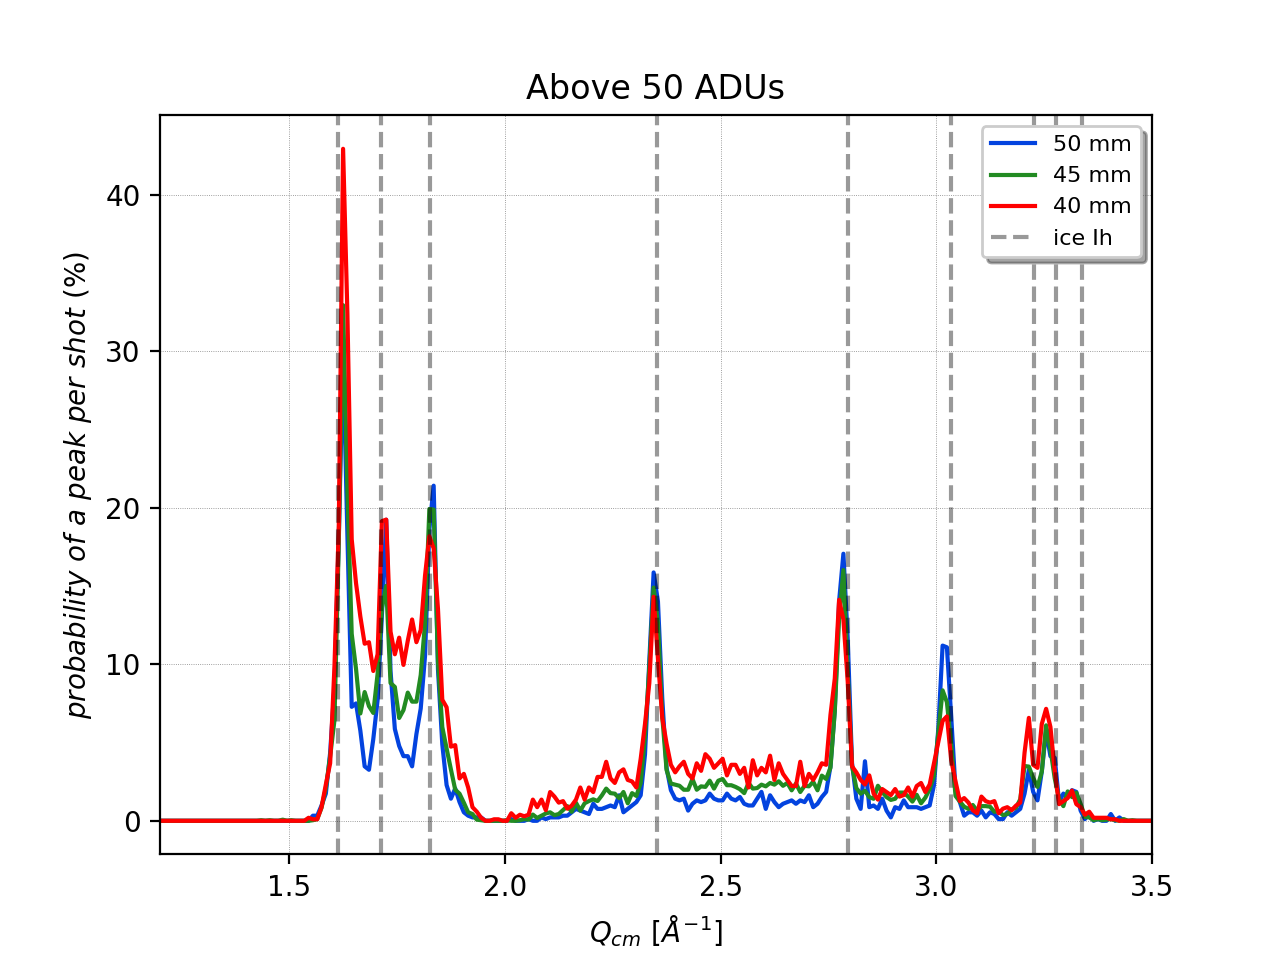

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [69]:
# peak numbers vs q_cm center of mass in q scale
plt.figure()
binwidth = 0.001
binedges = np.arange(0-binwidth/2,5.0+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(large_q_w_abv, bins=binedges)
yhist_m, bin_edges_m = np.histogram(large_q_m_abv, bins=binedges)
yhist_c, bin_edges_c = np.histogram(large_q_c_abv, bins=binedges)
bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])
new_bins, new_q_cm_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_q_cm_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_q_cm_c = downsample(bin_centers3, yhist_c, size=10)

T_227, = plt.plot(new_bins, (new_q_cm_c/pershot_c_abv.sum())*100,  color='#0343DF')
T_228, = plt.plot(new_bins, (new_q_cm_m/pershot_m_abv.sum())*100,  color='forestgreen')
T_229, = plt.plot(new_bins, (new_q_cm_w/pershot_w_abv.sum())*100,  color='r')

xposition = iceIh_peaks()
for x,xc in enumerate(xposition[:-1]):
    ice_plot = plt.axvline(x=xc, color='k', linestyle='--', alpha=0.4)

plt.legend(handles=[T_227, T_228, T_229, ice_plot], labels=['50 mm', '45 mm', '40 mm', 'ice Ih'], loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Q_{cm}\ [\AA^{-1}]$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
plt.ylabel('$probability\ of\ a\ peak\ per\ shot\ (\%)$')
plt.xlim(1.2, 3.5)
plt.title('Above 50 ADUs')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.savefig('/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/LCLS_plots/qcm_above50ADUs.eps', format='eps')
plt.show()  

In [216]:
filterout_w_blw = Shot_for_sp(T_w, below50ADUs_w, choice = 'large_peaks')
filterout_m_blw = Shot_for_sp(T_m, below50ADUs_m, choice = 'large_peaks')
filterout_c_blw = Shot_for_sp(T_c, below50ADUs_c, choice = 'large_peaks')

In [217]:
large_q_c_blw = [list(d_values(filterout_c_blw, 3))[x]['q_cm'] for x in range(len(list(d_values(filterout_c_blw, 3))))]
large_q_c_blw = np.array(sorted(itertools.chain(*large_q_c_blw))).T

In [218]:
large_q_w_blw = [list(d_values(filterout_w_blw, 3))[t]['q_cm'] for t in range(len(list(d_values(filterout_w_blw, 3))))]
large_q_w_blw = np.array(sorted(itertools.chain(*large_q_w_blw))).T

In [219]:
large_q_m_blw = [list(d_values(filterout_m_blw, 3))[k]['q_cm'] for k in range(len(list(d_values(filterout_m_blw, 3))))]
large_q_m_blw = np.array(sorted(itertools.chain(*large_q_m_blw))).T

In [49]:
aw = [list(filterout_c_blw[run].keys()) for run in T_c]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_c_blw = np.array([len([s for s in fg if n in s]) for n in T_c])

In [50]:
qw = [list(filterout_w_abv[run].keys()) for run in T_w]
fg = np.array(sorted(itertools.chain(*qw))).T
pershot_w_blw = np.array([len([s for s in fg if n in s]) for n in T_w])

In [51]:
de = [list(filterout_m_abv[run].keys()) for run in T_m]
fg = np.array(sorted(itertools.chain(*de))).T
pershot_m_blw = np.array([len([s for s in fg if n in s]) for n in T_m])

<IPython.core.display.Javascript object>


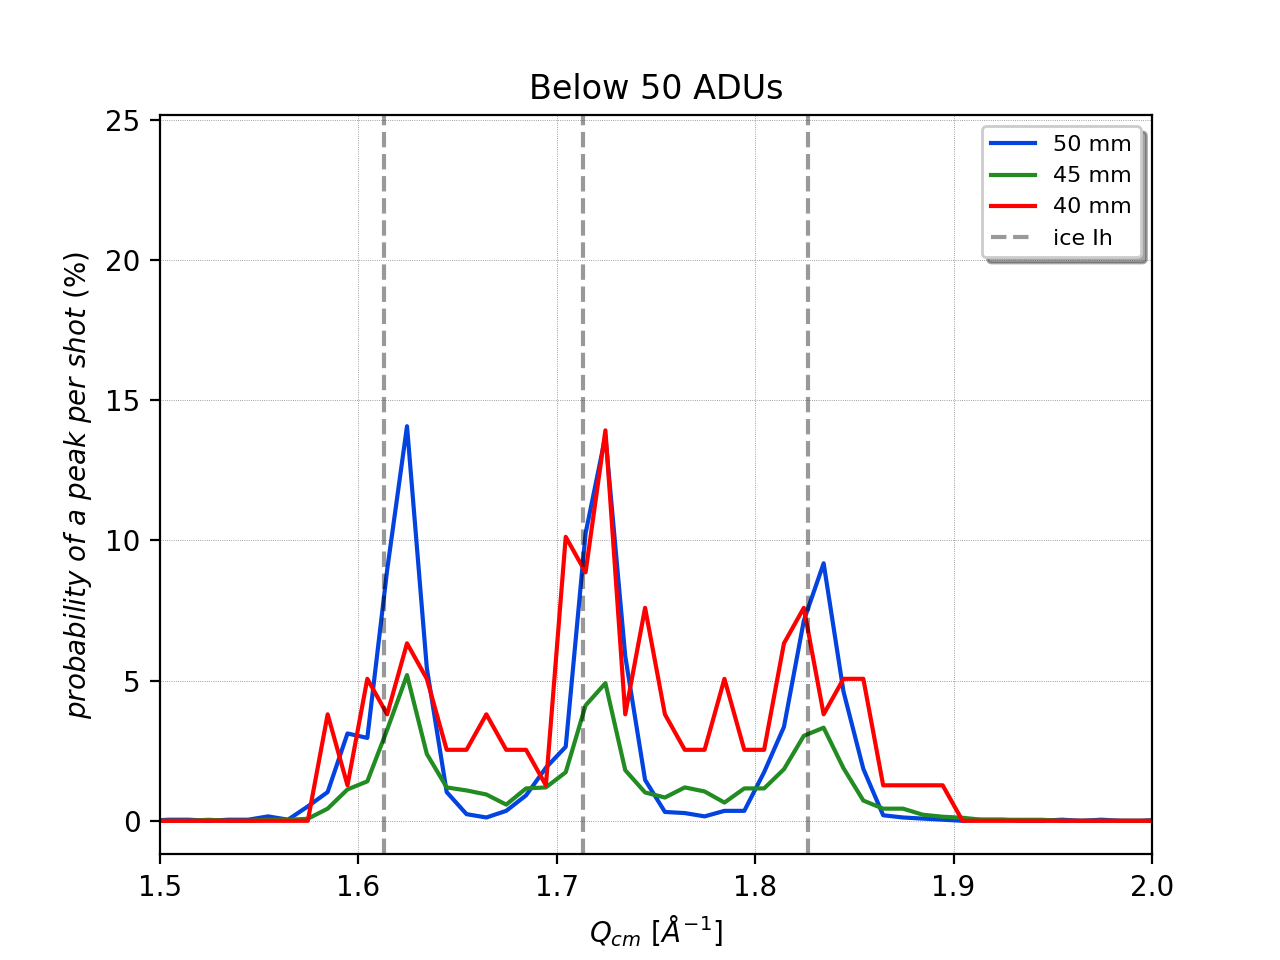

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [79]:
# peak numbers vs q_cm center of mass in q scale
plt.figure()
binwidth = 0.001
binedges = np.arange(0-binwidth/2,5.0+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(large_q_w_blw, bins=binedges)
yhist_m, bin_edges_m = np.histogram(large_q_m_blw, bins=binedges)
yhist_c, bin_edges_c = np.histogram(large_q_c_blw, bins=binedges)
bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])
new_bins, new_q_cm_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_q_cm_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_q_cm_c = downsample(bin_centers3, yhist_c, size=10)

T_227, = plt.plot(new_bins, (new_q_cm_c/pershot_c_blw.sum())*100,  color='#0343DF')
T_228, = plt.plot(new_bins, (new_q_cm_m/pershot_m_blw.sum())*100,  color='forestgreen')
T_229, = plt.plot(new_bins, (new_q_cm_w/pershot_w_blw.sum())*100,  color='r')


xposition = iceIh_peaks()
for x,xc in enumerate(xposition[:-1]):
    ice_plot = plt.axvline(x=xc, color='k', linestyle='--', alpha=0.4)

plt.legend(handles=[T_227, T_228, T_229, ice_plot], labels=['50 mm', '45 mm', '40 mm', 'ice Ih'], loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Q_{cm}\ [\AA^{-1}]$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
plt.ylabel('$probability\ of\ a\ peak\ per\ shot\ (\%)$')
plt.xlim(1.5, 2.)
plt.title('Below 50 ADUs')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.savefig('/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/LCLS_plots/qcm_below50ADUs.eps', format='eps')
plt.show()  

In [680]:
def give_shots_several_maxima(dict_1):
    dict_out = {}
    for run in dict_1.keys():
        for shot in dict_1[run]:
            for peak in dict_1[run][shot]:
                if dict_1[run][shot][peak]['Otsu_Number_of_maxima'] > 1:
                    dict_out = dict_1                                
    return dict_out
                    
def give_shots_one_maxima(dict_1):
    for run in dict_1.keys():
        for shot in dict_1[run]:
            for peak in dict_1[run][shot]:
                if dict_1[run][shot][peak]['Otsu_Number_of_maxima'] == 1:
                    print(shot, peak)

In [410]:
# Case 1
# what could be single blobs?
'''
If it is only one single peak that has a sphericity of 0.7 and a minimum distance of 0.25 A-1, then it is 
most probably a single blob as proposed in grant proposal
'''
# all single peaks 
case_1_Tc_abv = Shot_for_sp(T_c, above_50ADUs_c, area_thr = 10, choice = 'large_peaks', n_Max =1, lower_qcm= 0, upper_qcm = 5, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.25, maximum_d = 8, I_min = 0, I_max = 1.1)

In [411]:
case_1_Tm_abv = Shot_for_sp(T_m, above_50ADUs_m, area_thr = 10, choice = 'large_peaks', n_Max =1, lower_qcm= 0, upper_qcm = 5, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.25, maximum_d = 8, I_min = 0, I_max = 1.1)

In [412]:
case_1_Tw_abv = Shot_for_sp(T_w, above_50ADUs_w, area_thr = 10, choice = 'large_peaks', n_Max =1, lower_qcm= 0, upper_qcm = 5, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.25, maximum_d = 8, I_min = 0, I_max = 1.1)

In [484]:
len([list(d_values(case_1_Tc_abv, 2))[x] for x in range(len(list(d_values(case_1_Tc_abv, 2))))])

715

In [602]:
te = [list(d_values(case_1_Tc_abv, 1))[x] for x in range(len(list(d_values(case_1_Tc_abv, 1))))]
np.shape(np.array(sorted(itertools.chain(*te))).T)

[{'LCLS_2011_Feb28_r0165_232503_fb0a_cspad': {'peak1': {'q_cm': array([1.61627347]),
    'sphericity': 0.8236593100537102,
    'area': 42.0,
    'perimeter': 25.313708305358887,
    'rel_intensities': 0.7019093013667203,
    'Number_of_maxima': 1,
    'all_distances': array([1.77025122, 2.3110136 , 2.29594788, 2.39051773]),
    'min_distance': 1.770251219421218}},
  'LCLS_2011_Feb28_r0165_232435_d39b_cspad': {'peak1': {'q_cm': array([1.61363608]),
    'sphericity': 0.8464523193398272,
    'area': 21.0,
    'perimeter': 17.656854152679443,
    'rel_intensities': 0.5301907898175736,
    'Number_of_maxima': 1,
    'all_distances': array([4.33889455, 1.38698627, 1.41801648]),
    'min_distance': 1.3869862700830822}},
  'LCLS_2011_Feb28_r0165_232521_113cd_cspad': {'peak9': {'q_cm': array([1.63079029]),
    'sphericity': 0.8363009706092603,
    'area': 13.5,
    'perimeter': 14.242640614509583,
    'rel_intensities': 0.6677124987892792,
    'Number_of_maxima': 1,
    'all_distances': array([

In [486]:
# Single blob (case 1) for (100) reflection 
min_bound = iceIh_peaks()[0]-0.05
max_bound = iceIh_peaks()[0]+0.05
case_1_Tc_abv_100 = Shot_for_sp(T_c, above_50ADUs_c, area_thr = 10, choice = 'large_peaks', n_Max =1, lower_qcm= min_bound, upper_qcm = max_bound, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.25, maximum_d = 8, I_min = 0, I_max = 1.1)
case_1_Tm_abv_100 = Shot_for_sp(T_m, above_50ADUs_m, area_thr = 10, choice = 'large_peaks', n_Max =1, lower_qcm= min_bound, upper_qcm = max_bound, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.25, maximum_d = 8, I_min = 0, I_max = 1.1)
case_1_Tw_abv_100 = Shot_for_sp(T_w, above_50ADUs_w, area_thr = 10, choice = 'large_peaks', n_Max =1, lower_qcm= min_bound, upper_qcm = max_bound, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.25, maximum_d = 8, I_min = 0, I_max = 1.1)

In [496]:
aw = [list(case_1_Tc_abv_100[run].keys()) for run in T_c]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_c_abv_100 = np.array([len([s for s in fg if n in s]) for n in T_c])

In [498]:
aw = [list(case_1_Tm_abv_100[run].keys()) for run in T_m]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_m_abv_100 = np.array([len([s for s in fg if n in s]) for n in T_m])

In [499]:
aw = [list(case_1_Tw_abv_100[run].keys()) for run in T_w]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_w_abv_100 = np.array([len([s for s in fg if n in s]) for n in T_w])

In [492]:
case_1_Tc_s_abv_100 = [list(d_values(case_1_Tc_abv_100, 3))[x]['sphericity'] for x in range(len(list(d_values(case_1_Tc_abv_100, 3))))]
case_1_Tm_s_abv_100 = [list(d_values(case_1_Tm_abv_100, 3))[x]['sphericity'] for x in range(len(list(d_values(case_1_Tm_abv_100, 3))))]
case_1_Tw_s_abv_100 = [list(d_values(case_1_Tw_abv_100, 3))[x]['sphericity'] for x in range(len(list(d_values(case_1_Tw_abv_100, 3))))]

<IPython.core.display.Javascript object>


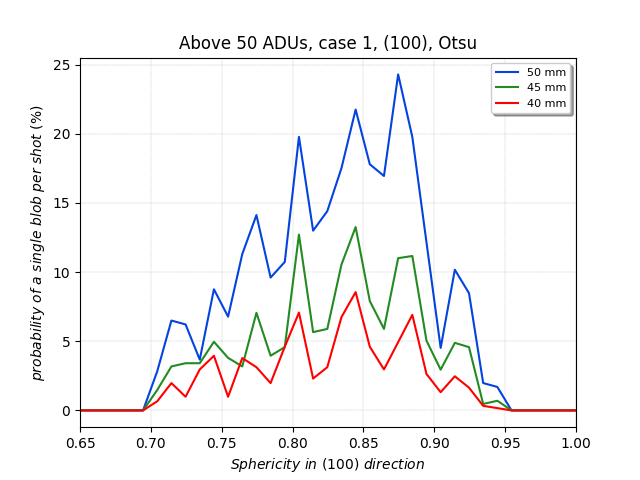

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [591]:
# peak numbers vs q_cm center of mass in q scale
plt.figure()
binwidth = 0.001
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(case_1_Tc_s_abv_100, bins=binedges)
yhist_m, bin_edges_m = np.histogram(case_1_Tm_s_abv_100, bins=binedges)
yhist_c, bin_edges_c = np.histogram(case_1_Tw_s_abv_100, bins=binedges)
bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])
new_bins, new_q_cm_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_q_cm_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_q_cm_c = downsample(bin_centers3, yhist_c, size=10)

T_227, = plt.plot(new_bins, (new_q_cm_c/pershot_c_abv_100.sum())*100, color='#0343DF')
T_228, = plt.plot(new_bins, (new_q_cm_m/pershot_m_abv_100.sum())*100, color='forestgreen')
T_229, = plt.plot(new_bins, (new_q_cm_w/pershot_w_abv_100.sum())*100, color='r')


plt.legend(handles=[T_227, T_228, T_229, ice_plot], labels=['50 mm', '45 mm', '40 mm'], loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Sphericity\ in\ (100)\ direction$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
plt.ylabel('$probability\ of\ a\ single\ blob\ per\ shot\ (\%)$')
plt.xlim(0.65, 1.)
plt.title('Above 50 ADUs, case 1, (100), Otsu')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.savefig('/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/LCLS_plots/case1_100.eps', format='eps')
plt.show()  

In [551]:
# Single blob (case 1) for (002) reflection 
min_bound = iceIh_peaks()[1]-0.05
max_bound = iceIh_peaks()[1]+0.05
case_1_Tc_abv_002 = Shot_for_sp(T_c, above_50ADUs_c, area_thr = 10, choice = 'large_peaks', n_Max =1, lower_qcm= min_bound, upper_qcm = max_bound, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.25, maximum_d = 8, I_min = 0, I_max = 1.1)
case_1_Tm_abv_002 = Shot_for_sp(T_m, above_50ADUs_m, area_thr = 10, choice = 'large_peaks', n_Max =1, lower_qcm= min_bound, upper_qcm = max_bound, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.25, maximum_d = 8, I_min = 0, I_max = 1.1)
case_1_Tw_abv_002 = Shot_for_sp(T_w, above_50ADUs_w, area_thr = 10, choice = 'large_peaks', n_Max =1, lower_qcm= min_bound, upper_qcm = max_bound, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.25, maximum_d = 8, I_min = 0, I_max = 1.1)

In [562]:
aw = [list(case_1_Tc_abv_002[run].keys()) for run in T_c]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_c_abv_002 = np.array([len([s for s in fg if n in s]) for n in T_c])

In [563]:
aw = [list(case_1_Tm_abv_002[run].keys()) for run in T_m]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_m_abv_002 = np.array([len([s for s in fg if n in s]) for n in T_m])

In [564]:
aw = [list(case_1_Tw_abv_002[run].keys()) for run in T_w]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_w_abv_002 = np.array([len([s for s in fg if n in s]) for n in T_w])

In [566]:
case_1_Tc_s_abv_002 = [list(d_values(case_1_Tc_abv_002, 3))[x]['sphericity'] for x in range(len(list(d_values(case_1_Tc_abv_002, 3))))]
case_1_Tm_s_abv_002 = [list(d_values(case_1_Tm_abv_002, 3))[x]['sphericity'] for x in range(len(list(d_values(case_1_Tm_abv_002, 3))))]
case_1_Tw_s_abv_002 = [list(d_values(case_1_Tw_abv_002, 3))[x]['sphericity'] for x in range(len(list(d_values(case_1_Tw_abv_002, 3))))]

<IPython.core.display.Javascript object>


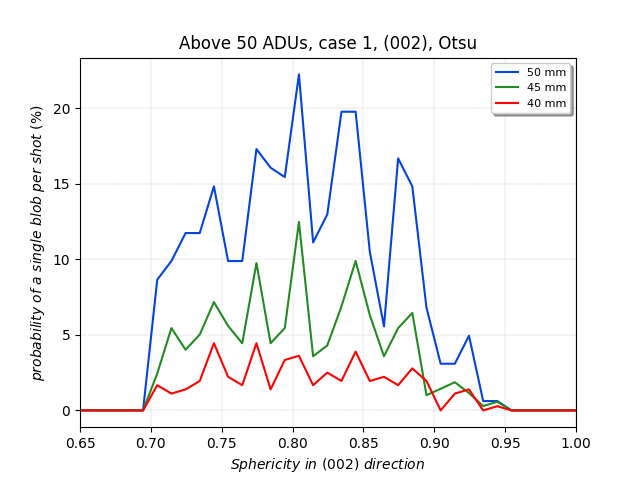

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [592]:
# peak numbers vs q_cm center of mass in q scale
plt.figure()
binwidth = 0.001
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(case_1_Tc_s_abv_002, bins=binedges)
yhist_m, bin_edges_m = np.histogram(case_1_Tm_s_abv_002, bins=binedges)
yhist_c, bin_edges_c = np.histogram(case_1_Tw_s_abv_002, bins=binedges)
bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])
new_bins, new_q_cm_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_q_cm_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_q_cm_c = downsample(bin_centers3, yhist_c, size=10)

T_227, = plt.plot(new_bins, (new_q_cm_c/pershot_c_abv_002.sum())*100, color='#0343DF')
T_228, = plt.plot(new_bins, (new_q_cm_m/pershot_m_abv_002.sum())*100, color='forestgreen')
T_229, = plt.plot(new_bins, (new_q_cm_w/pershot_w_abv_002.sum())*100, color='r')


plt.legend(handles=[T_227, T_228, T_229], labels=['50 mm', '45 mm', '40 mm'], loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Sphericity\ in\ (002)\ direction$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
plt.ylabel('$probability\ of\ a\ single\ blob\ per\ shot\ (\%)$')
plt.xlim(0.65, 1.)
plt.title('Above 50 ADUs, case 1, (002), Otsu')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.savefig('/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/LCLS_plots/case1_002.eps', format='eps')
plt.show()  

In [573]:
# Single blob (case 1) for (101) reflection 
min_bound = iceIh_peaks()[2]-0.05
max_bound = iceIh_peaks()[2]+0.05
case_1_Tc_abv_101 = Shot_for_sp(T_c, above_50ADUs_c, area_thr = 10, choice = 'large_peaks', n_Max =1, lower_qcm= min_bound, upper_qcm = max_bound, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.25, maximum_d = 8, I_min = 0, I_max = 1.1)
case_1_Tm_abv_101 = Shot_for_sp(T_m, above_50ADUs_m, area_thr = 10, choice = 'large_peaks', n_Max =1, lower_qcm= min_bound, upper_qcm = max_bound, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.25, maximum_d = 8, I_min = 0, I_max = 1.1)
case_1_Tw_abv_101 = Shot_for_sp(T_w, above_50ADUs_w, area_thr = 10, choice = 'large_peaks', n_Max =1, lower_qcm= min_bound, upper_qcm = max_bound, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.25, maximum_d = 8, I_min = 0, I_max = 1.1)

In [574]:
case_1_Tc_s_abv_101 = [list(d_values(case_1_Tc_abv_101, 3))[x]['sphericity'] for x in range(len(list(d_values(case_1_Tc_abv_101, 3))))]
case_1_Tm_s_abv_101 = [list(d_values(case_1_Tm_abv_101, 3))[x]['sphericity'] for x in range(len(list(d_values(case_1_Tm_abv_101, 3))))]
case_1_Tw_s_abv_101 = [list(d_values(case_1_Tw_abv_101, 3))[x]['sphericity'] for x in range(len(list(d_values(case_1_Tw_abv_101, 3))))]

In [575]:
aw = [list(case_1_Tc_abv_101[run].keys()) for run in T_c]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_c_abv_101 = np.array([len([s for s in fg if n in s]) for n in T_c])

In [576]:
aw = [list(case_1_Tm_abv_101[run].keys()) for run in T_m]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_m_abv_101 = np.array([len([s for s in fg if n in s]) for n in T_m])

In [577]:
aw = [list(case_1_Tw_abv_101[run].keys()) for run in T_w]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_w_abv_101 = np.array([len([s for s in fg if n in s]) for n in T_w])

<IPython.core.display.Javascript object>


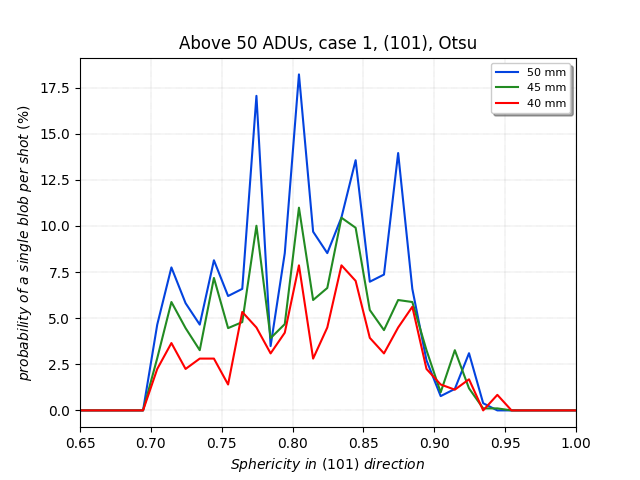

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [594]:
# peak numbers vs q_cm center of mass in q scale
plt.figure()
binwidth = 0.001
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(case_1_Tc_s_abv_101, bins=binedges)
yhist_m, bin_edges_m = np.histogram(case_1_Tm_s_abv_101, bins=binedges)
yhist_c, bin_edges_c = np.histogram(case_1_Tw_s_abv_101, bins=binedges)
bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])
new_bins, new_q_cm_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_q_cm_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_q_cm_c = downsample(bin_centers3, yhist_c, size=10)

T_227, = plt.plot(new_bins, (new_q_cm_c/pershot_c_abv_101.sum())*100, color='#0343DF')
T_228, = plt.plot(new_bins, (new_q_cm_m/pershot_m_abv_101.sum())*100, color='forestgreen')
T_229, = plt.plot(new_bins, (new_q_cm_w/pershot_w_abv_101.sum())*100, color='r')


plt.legend(handles=[T_227, T_228, T_229], labels=['50 mm', '45 mm', '40 mm'], loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Sphericity\ in\ (101)\ direction$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
plt.ylabel('$probability\ of\ a\ single\ blob\ per\ shot\ (\%)$')
plt.xlim(0.65, 1.)
plt.title('Above 50 ADUs, case 1, (101), Otsu')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.savefig('/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/LCLS_plots/case1_101.eps', format='eps')
plt.show()  

In [581]:
# Single blob (case 1) for (102) reflection 
min_bound = iceIh_peaks()[3]-0.05
max_bound = iceIh_peaks()[3]+0.05
case_1_Tc_abv_102 = Shot_for_sp(T_c, above_50ADUs_c, area_thr = 10, choice = 'large_peaks', n_Max =1, lower_qcm= min_bound, upper_qcm = max_bound, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.25, maximum_d = 8, I_min = 0, I_max = 1.1)
case_1_Tm_abv_102 = Shot_for_sp(T_m, above_50ADUs_m, area_thr = 10, choice = 'large_peaks', n_Max =1, lower_qcm= min_bound, upper_qcm = max_bound, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.25, maximum_d = 8, I_min = 0, I_max = 1.1)
case_1_Tw_abv_102 = Shot_for_sp(T_w, above_50ADUs_w, area_thr = 10, choice = 'large_peaks', n_Max =1, lower_qcm= min_bound, upper_qcm = max_bound, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.25, maximum_d = 8, I_min = 0, I_max = 1.1)

In [584]:
# Single blob (case 1) for (100) reflection 
min_bound = iceIh_peaks()[0]-0.05
max_bound = iceIh_peaks()[0]+0.05
case_1_Tc_abv_log_100 = logarithmic_approach(T_c, above_50ADUs_c, area_thr = 10, choice = 'large_peaks', n_Max =1, lower_qcm= min_bound, upper_qcm = max_bound, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.25, maximum_d = 8, I_min = 0, I_max = 1.1)
case_1_Tm_abv_log_100 = logarithmic_approach(T_m, above_50ADUs_m, area_thr = 10, choice = 'large_peaks', n_Max =1, lower_qcm= min_bound, upper_qcm = max_bound, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.25, maximum_d = 8, I_min = 0, I_max = 1.1)
case_1_Tw_abv_log_100 = logarithmic_approach(T_w, above_50ADUs_w, area_thr = 10, choice = 'large_peaks', n_Max =1, lower_qcm= min_bound, upper_qcm = max_bound, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.25, maximum_d = 8, I_min = 0, I_max = 1.1)

In [585]:
aw = [list(case_1_Tc_abv_log_100[run].keys()) for run in T_c]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_c_abv_log_100 = np.array([len([s for s in fg if n in s]) for n in T_c])

In [586]:
aw = [list(case_1_Tm_abv_log_100[run].keys()) for run in T_m]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_m_abv_log_100 = np.array([len([s for s in fg if n in s]) for n in T_m])

In [587]:
aw = [list(case_1_Tw_abv_log_100[run].keys()) for run in T_w]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_w_abv_log_100 = np.array([len([s for s in fg if n in s]) for n in T_w])

In [588]:
case_1_Tc_abv_log_100 = [list(d_values(case_1_Tc_abv_log_100, 3))[x]['sphericity'] for x in range(len(list(d_values(case_1_Tc_abv_log_100, 3))))]
case_1_Tm_abv_log_100 = [list(d_values(case_1_Tm_abv_log_100, 3))[x]['sphericity'] for x in range(len(list(d_values(case_1_Tm_abv_log_100, 3))))]
case_1_Tw_abv_log_100 = [list(d_values(case_1_Tw_abv_log_100, 3))[x]['sphericity'] for x in range(len(list(d_values(case_1_Tw_abv_log_100, 3))))]

<IPython.core.display.Javascript object>


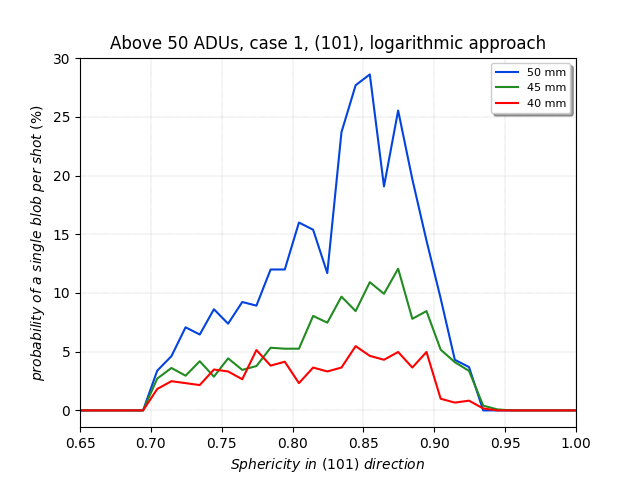

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [595]:
# peak numbers vs q_cm center of mass in q scale
plt.figure()
binwidth = 0.001
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(case_1_Tc_abv_log_100, bins=binedges)
yhist_m, bin_edges_m = np.histogram(case_1_Tm_abv_log_100, bins=binedges)
yhist_c, bin_edges_c = np.histogram(case_1_Tw_abv_log_100, bins=binedges)
bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])
new_bins, new_q_cm_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_q_cm_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_q_cm_c = downsample(bin_centers3, yhist_c, size=10)

T_227, = plt.plot(new_bins, (new_q_cm_c/pershot_c_abv_log_100.sum())*100, color='#0343DF')
T_228, = plt.plot(new_bins, (new_q_cm_m/pershot_m_abv_log_100.sum())*100, color='forestgreen')
T_229, = plt.plot(new_bins, (new_q_cm_w/pershot_w_abv_log_100.sum())*100, color='r')


plt.legend(handles=[T_227, T_228, T_229], labels=['50 mm', '45 mm', '40 mm'], loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Sphericity\ in\ (101)\ direction$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
plt.ylabel('$probability\ of\ a\ single\ blob\ per\ shot\ (\%)$')
plt.xlim(0.65, 1.)
plt.title('Above 50 ADUs, case 1, (101), logarithmic approach')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.savefig('/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/LCLS_plots/case1_101.eps', format='eps')
plt.show()  

In [596]:
# Single blob (case 1) for (002) reflection 
min_bound = iceIh_peaks()[1]-0.05
max_bound = iceIh_peaks()[1]+0.05
case_1_Tc_abv_log_002 = logarithmic_approach(T_c, above_50ADUs_c, area_thr = 10, choice = 'large_peaks', n_Max =1, lower_qcm= min_bound, upper_qcm = max_bound, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.25, maximum_d = 8, I_min = 0, I_max = 1.1)
case_1_Tm_abv_log_002 = logarithmic_approach(T_m, above_50ADUs_m, area_thr = 10, choice = 'large_peaks', n_Max =1, lower_qcm= min_bound, upper_qcm = max_bound, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.25, maximum_d = 8, I_min = 0, I_max = 1.1)
case_1_Tw_abv_log_002 = logarithmic_approach(T_w, above_50ADUs_w, area_thr = 10, choice = 'large_peaks', n_Max =1, lower_qcm= min_bound, upper_qcm = max_bound, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.25, maximum_d = 8, I_min = 0, I_max = 1.1)

In [597]:
aw = [list(case_1_Tc_abv_log_002[run].keys()) for run in T_c]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_c_abv_log_002 = np.array([len([s for s in fg if n in s]) for n in T_c])

In [598]:
aw = [list(case_1_Tm_abv_log_002[run].keys()) for run in T_m]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_m_abv_log_002 = np.array([len([s for s in fg if n in s]) for n in T_m])

In [599]:
aw = [list(case_1_Tw_abv_log_002[run].keys()) for run in T_w]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_w_abv_log_002 = np.array([len([s for s in fg if n in s]) for n in T_w])

In [600]:
case_1_Tc_abv_log_002 = [list(d_values(case_1_Tc_abv_log_002, 3))[x]['sphericity'] for x in range(len(list(d_values(case_1_Tc_abv_log_002, 3))))]
case_1_Tm_abv_log_002 = [list(d_values(case_1_Tm_abv_log_002, 3))[x]['sphericity'] for x in range(len(list(d_values(case_1_Tm_abv_log_002, 3))))]
case_1_Tw_abv_log_002 = [list(d_values(case_1_Tw_abv_log_002, 3))[x]['sphericity'] for x in range(len(list(d_values(case_1_Tw_abv_log_002, 3))))]

<IPython.core.display.Javascript object>


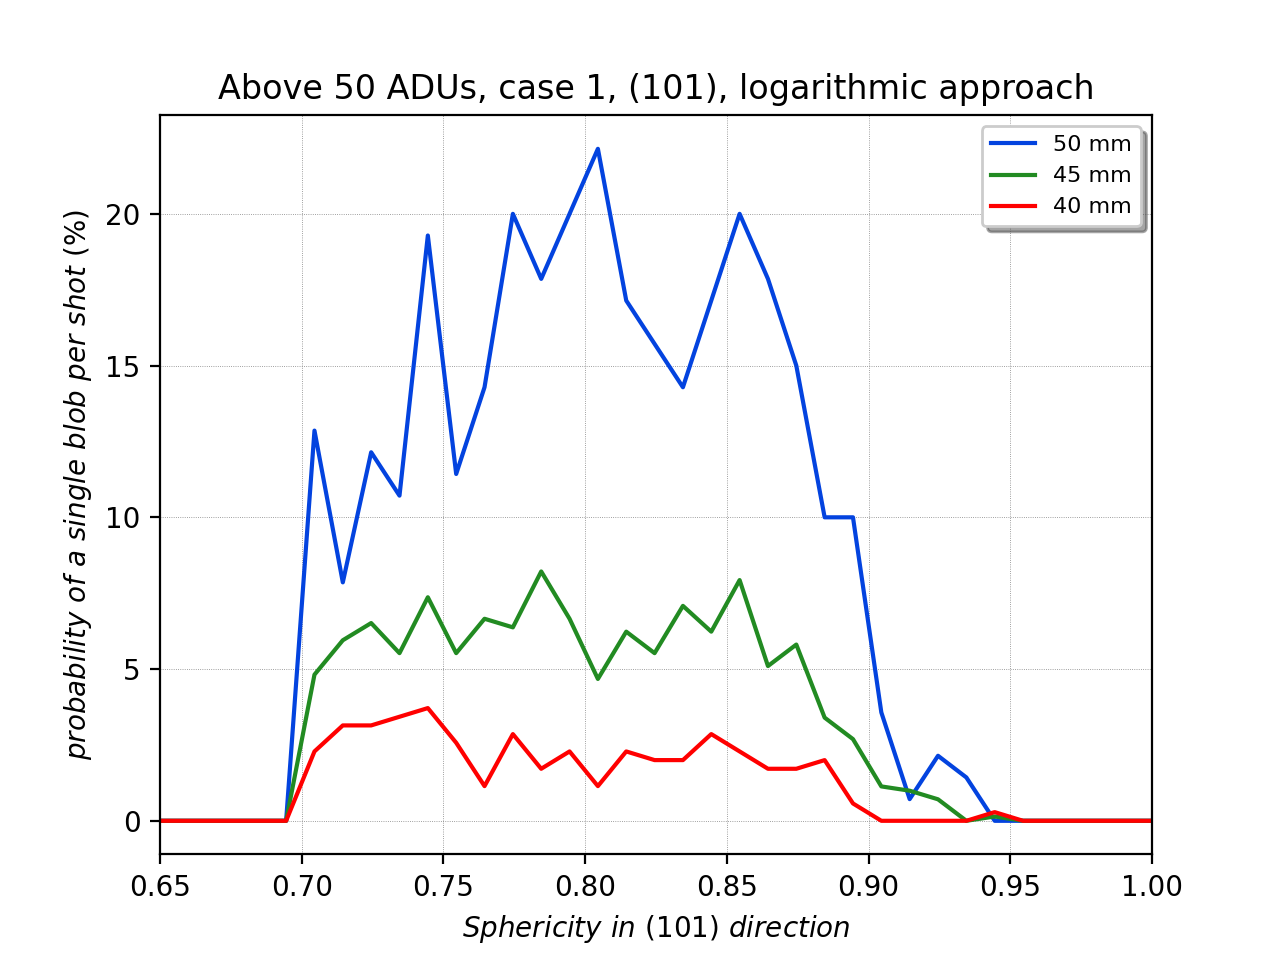

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [601]:
# peak numbers vs q_cm center of mass in q scale
plt.figure()
binwidth = 0.001
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(case_1_Tc_abv_log_002, bins=binedges)
yhist_m, bin_edges_m = np.histogram(case_1_Tm_abv_log_002, bins=binedges)
yhist_c, bin_edges_c = np.histogram(case_1_Tw_abv_log_002, bins=binedges)
bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])
new_bins, new_q_cm_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_q_cm_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_q_cm_c = downsample(bin_centers3, yhist_c, size=10)

T_227, = plt.plot(new_bins, (new_q_cm_c/pershot_c_abv_log_002.sum())*100, color='#0343DF')
T_228, = plt.plot(new_bins, (new_q_cm_m/pershot_m_abv_log_002.sum())*100, color='forestgreen')
T_229, = plt.plot(new_bins, (new_q_cm_w/pershot_w_abv_log_002.sum())*100, color='r')


plt.legend(handles=[T_227, T_228, T_229], labels=['50 mm', '45 mm', '40 mm'], loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
plt.xlabel('$Sphericity\ in\ (101)\ direction$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
plt.ylabel('$probability\ of\ a\ single\ blob\ per\ shot\ (\%)$')
plt.xlim(0.65, 1.)
plt.title('Above 50 ADUs, case 1, (101), logarithmic approach')
plt.grid(c = 'grey',linestyle=':', linewidth=0.3)
plt.savefig('/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/LCLS_plots/case1_101.eps', format='eps')
plt.show()  

In [25]:
dict_all_c = Shot_for_sp(T_c, above_50ADUs_c, area_thr = 10, choice = 'large_peaks', n_Max =None, lower_qcm= -1, upper_qcm = 10, lower_sphericity =-0.5, upper_sphericity=1.1, minimum_d = 0, maximum_d = 9, I_min = 0, I_max = 1.1)
#logarithmic_approach(T_c, above_50ADUs_c, area_thr = 10, choice = 'large_peaks', n_Max =1, lower_qcm= min_bound, upper_qcm = max_bound, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.25, maximum_d = 8, I_min = 0, I_max = 1.1)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log


In [20]:
# Save the dictionary and open it later
import pickle

#with open('dict_all_c.pkl','wb') as f:
#    pickle.dump(dict_all_c, f)
    
    
with open('dict_all_w.pkl','rb') as f:
    x = pickle.load(f)

In [26]:
dict_all_m = Shot_for_sp(T_m, above_50ADUs_m, area_thr = 10, choice = 'large_peaks', n_Max =None, lower_qcm= -1, upper_qcm = 10, lower_sphericity =-0.5, upper_sphericity=1.1, minimum_d = 0, maximum_d = 9, I_min = 0, I_max = 1.1)
#logarithmic_approach(T_c, above_50ADUs_c, area_thr = 10, choice = 'large_peaks', n_Max =1, lower_qcm= min_bound, upper_qcm = max_bound, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.25, maximum_d = 8, I_min = 0, I_max = 1.1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log


In [27]:
dict_all_w = Shot_for_sp(T_w, above_50ADUs_w, area_thr = 10, choice = 'large_peaks', n_Max =None, lower_qcm= -1, upper_qcm = 10, lower_sphericity =-0.5, upper_sphericity=1.1, minimum_d = 0, maximum_d = 9, I_min = 0, I_max = 1.1)
#logarithmic_approach(T_c, above_50ADUs_c, area_thr = 10, choice = 'large_peaks', n_Max =1, lower_qcm= min_bound, upper_qcm = max_bound, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.25, maximum_d = 8, I_min = 0, I_max = 1.1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log


In [661]:
with open('dict_all_m.pkl','wb') as f:
    pickle.dump(dict_all_m, f)

In [665]:
with open('dict_all_w.pkl','wb') as f:
    pickle.dump(dict_all_w, f)

In [28]:
dict_case1_c = Shot_for_sp(T_c, above_50ADUs_c, area_thr = 10, choice = 'large_peaks', n_Max = 1, lower_qcm= -1, upper_qcm = 10, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.2, maximum_d = 9, I_min = 0, I_max = 1.1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log


In [29]:
dict_case1_m = Shot_for_sp(T_m, above_50ADUs_m, area_thr = 10, choice = 'large_peaks', n_Max = 1, lower_qcm= -1, upper_qcm = 10, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.2, maximum_d = 9, I_min = 0, I_max = 1.1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log


In [19]:
dict_case1_w = Shot_for_sp(T_w, above_50ADUs_w, area_thr = 10, choice = 'large_peaks', n_Max = 1, lower_qcm= -1, upper_qcm = 10, lower_sphericity =0.7, upper_sphericity=1.1, minimum_d = 0.2, maximum_d = 9, I_min = 0, I_max = 1.1)

In [22]:
dict_case2_w

{'r0144': {'LCLS_2011_Feb28_r0144_163258_12114_cspad': {'peak1': {'q_cm': array([1.77588542]),
    'Otsu_sphericity': 0.2815668115440982,
    'Otsu_area': 157.5,
    'Otsu_perimeter': 83.84061968326569,
    'Otsu_max_intensity': 0.7442752128616003,
    'Otsu_Number_of_maxima': 1,
    'log-Otsu_sphericity': 0.5321127373159085,
    'log-Otsu_area': 308.5,
    'log-Otsu_perimeter': 85.35533845424652,
    'log-Otsu_max_intensity': 0.8816597751070918,
    'log-Otsu_Number_of_maxima': 1,
    'all_distances': [array([2.6296799 , 1.87714806, 1.77052244, 0.9553147 , 2.6426292 ,
            2.83713757, 2.94351905, 3.04977901, 3.14804175, 3.37632636,
            4.58129512])],
    'min_distance': [0.9553147033321214]}},
  'LCLS_2011_Feb28_r0144_164410_d215_cspad': {'peak1': {'q_cm': array([2.4268581]),
    'Otsu_sphericity': 0.29020849235104057,
    'Otsu_area': 94.0,
    'Otsu_perimeter': 63.79898953437805,
    'Otsu_max_intensity': 0.7934224349034369,
    'Otsu_Number_of_maxima': 1,
    'log-Ot

In [640]:
with open('dict_case1_c.pkl','wb') as f:
    pickle.dump(dict_case1_c, f)

In [641]:
with open('dict_case1_m.pkl','wb') as f:
    pickle.dump(dict_case1_m, f)

In [18]:
with open('dict_case1_w.pkl','wb') as f:
    pickle.dump(dict_case1_w, f)

NameError: name 'dict_case1_w' is not defined

In [669]:
# case 2 sphericity < 0.3 and PCF > 0.2
dict_case2_c = Shot_for_sp(T_c, above_50ADUs_c, area_thr = 10, choice = 'large_peaks', n_Max = 1, lower_qcm= -1, upper_qcm = 10, lower_sphericity =-1, upper_sphericity=0.3, minimum_d = 0.2, maximum_d = 9, I_min = 0, I_max = 1.1)

In [670]:
dict_case2_m = Shot_for_sp(T_m, above_50ADUs_m, area_thr = 10, choice = 'large_peaks', n_Max = 1, lower_qcm= -1, upper_qcm = 10, lower_sphericity =-1, upper_sphericity=0.3, minimum_d = 0.2, maximum_d = 9, I_min = 0, I_max = 1.1)

In [21]:
dict_case2_w = Shot_for_sp(T_w, above_50ADUs_w, area_thr = 10, choice = 'large_peaks', n_Max = 1, lower_qcm= -1, upper_qcm = 10, lower_sphericity =-1, upper_sphericity=0.3, minimum_d = 0.2, maximum_d = 9, I_min = 0, I_max = 1.1)

In [648]:
with open('dict_case2_c.pkl','wb') as f:
    pickle.dump(dict_case2_c, f)

In [647]:
with open('dict_case2_m.pkl','wb') as f:
    pickle.dump(dict_case2_m, f)

In [649]:
with open('dict_case2_w.pkl','wb') as f:
    pickle.dump(dict_case2_w, f)

In [ ]:
def give_shots_several_maxima(dict_1):
    dict_out = {}
    for run in dict_1.keys():
        for shot in dict_1[run]:
            for peak in dict_1[run][shot]:
                if dict_1[run][shot][peak]['Otsu_Number_of_maxima'] > 1:
                    dict_out = dict_1                                
    return dict_out


In [18]:
def filterTheDict(input_dict):
    newDict ={}
    for run in input_dict.keys():
        newDict[run] ={}
        for shot in input_dict[run]:
            newDict[run][shot] ={}
            for peak in input_dict[run][shot]:
                if input_dict[run][shot][peak]['Otsu_Number_of_maxima'] > 1:
                    newDict[run][shot][peak] = {}
                    newDict[run][shot][peak] = input_dict[run][shot][peak]
    return newDict

In [23]:
# case 3 multiple peaks (n_maxima>1)
dict_case3_c = filterTheDict(dict_all_c)
dict_case3_m = filterTheDict(dict_all_m)
dict_case3_w = filterTheDict(dict_all_w)

NameError: name 'filterTheDict' is not defined

In [769]:
# case 4 only 1 maxima but pcf<0.2 (n_maxima=1)
dict_case4_c = Shot_for_sp(T_c, above_50ADUs_c, area_thr = 10, choice = 'large_peaks', n_Max = 1, lower_qcm= -1, upper_qcm = 10, lower_sphericity =-1, upper_sphericity=1.1, minimum_d = 0, maximum_d = 0.2, I_min = 0, I_max = 1.1)
dict_case4_m = Shot_for_sp(T_m, above_50ADUs_m, area_thr = 10, choice = 'large_peaks', n_Max = 1, lower_qcm= -1, upper_qcm = 10, lower_sphericity =-1, upper_sphericity=1.1, minimum_d = 0, maximum_d = 0.2, I_min = 0, I_max = 1.1)
dict_case4_w = Shot_for_sp(T_w, above_50ADUs_w, area_thr = 10, choice = 'large_peaks', n_Max = 1, lower_qcm= -1, upper_qcm = 10, lower_sphericity =-1, upper_sphericity=1.1, minimum_d = 0, maximum_d = 0.2, I_min = 0, I_max = 1.1)


In [31]:
# sphericity Otsu vs log for all q_cm range whole dic 
aw = [list(dict_all_c[run].keys()) for run in T_c]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_dict_all_c = np.array([len([s for s in fg if n in s]) for n in T_c])

In [32]:
aw = [list(dict_all_m[run].keys()) for run in T_m]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_dict_all_m = np.array([len([s for s in fg if n in s]) for n in T_m])

In [33]:
aw = [list(dict_all_w[run].keys()) for run in T_w]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_dict_all_w = np.array([len([s for s in fg if n in s]) for n in T_w])

In [16]:
def filterTheDict_case1(input_dict, s_min_thr = 0, s_max_thr = 1.1, d_min_thr = 0., d_max_thr = 9):
    newDict ={}
    for run in input_dict.keys():
        newDict[run] ={}
        for shot in input_dict[run]:
            newDict[run][shot] ={}
            for peak in input_dict[run][shot]:
                if ((input_dict[run][shot][peak]['Otsu_sphericity'] >= s_min_thr) & (input_dict[run][shot][peak]['Otsu_sphericity'] < s_max_thr)):
                    if input_dict[run][shot][peak]['Otsu_Number_of_maxima'] == 1:
                        if ((input_dict[run][shot][peak]['min_distance'] >= d_min_thr) & (input_dict[run][shot][peak]['min_distance'] < d_max_thr)):
                            newDict[run][shot][peak] = {}
                            newDict[run][shot][peak] = input_dict[run][shot][peak]
    return newDict

In [74]:
newDict ={}
for run in dict_all_w.keys():
    newDict[run] ={}
    for shot in dict_all_w[run]:
        newDict[run][shot] ={}
        for peak in dict_all_w[run][shot]:
            try:
                if ((dict_all_w[run][shot][peak]['log-Otsu_sphericity'] >= 0.5) & (dict_all_w[run][shot][peak]['log-Otsu_sphericity'] < 1)):
                    if dict_all_w[run][shot][peak]['Otsu_Number_of_maxima'] == 1:
                        if ((dict_all_w[run][shot][peak]['min_distance'] >= 0) & (dict_all_w[run][shot][peak]['min_distance'] < 8)):
                            newDict[run][shot][peak] = {}
                            #newDict[run][shot][peak] = dict_all_w[run][shot][peak]
                            #print(shot, peak)
            except TypeError:
                print(run, shot, peak, dict_all_w[run][shot][peak])

r0169 LCLS_2011_Mar01_r0169_015125_13b27_cspad peak0 {'q_cm': array([3.1469292]), 'Otsu_sphericity': 0.37860599842313747, 'Otsu_area': 56.0, 'Otsu_perimeter': 43.11269783973694, 'Otsu_max_intensity': 0.9154738707530451, 'Otsu_Number_of_maxima': 1, 'log-Otsu_sphericity': None, 'log-Otsu_area': 0.0, 'log-Otsu_perimeter': 0.0, 'log-Otsu_max_intensity': 0.025980899227789938, 'log-Otsu_Number_of_maxima': 3, 'all_distances': array([0.04942149, 0.1318688 , 0.36363882, 0.36071823, 3.00496479,
       3.56717482, 5.08956805, 5.25188398]), 'min_distance': 0.04942149174560746}
r0169 LCLS_2011_Mar01_r0169_015125_13b27_cspad peak1 {'q_cm': array([3.15956766]), 'Otsu_sphericity': 0.3619185396279137, 'Otsu_area': 97.5, 'Otsu_perimeter': 58.18376553058624, 'Otsu_max_intensity': 0.9588207316316613, 'Otsu_Number_of_maxima': 1, 'log-Otsu_sphericity': None, 'log-Otsu_area': 0.0, 'log-Otsu_perimeter': 0.0, 'log-Otsu_max_intensity': 0.02260930703852543, 'log-Otsu_Number_of_maxima': 3, 'all_distances': array(

In [69]:
dict_all_w[run][shot][peak]

{'q_cm': array([3.1469292]),
 'Otsu_sphericity': 0.37860599842313747,
 'Otsu_area': 56.0,
 'Otsu_perimeter': 43.11269783973694,
 'Otsu_max_intensity': 0.9154738707530451,
 'Otsu_Number_of_maxima': 1,
 'log-Otsu_sphericity': None,
 'log-Otsu_area': 0.0,
 'log-Otsu_perimeter': 0.0,
 'log-Otsu_max_intensity': 0.025980899227789938,
 'log-Otsu_Number_of_maxima': 3,
 'all_distances': array([0.04942149, 0.1318688 , 0.36363882, 0.36071823, 3.00496479,
        3.56717482, 5.08956805, 5.25188398]),
 'min_distance': 0.04942149174560746}

In [982]:
newDict ={}
for run in dict_all_w.keys():
    newDict[run] ={}
    for shot in dict_all_w[run]:
        newDict[run][shot] ={}
        for peak in dict_all_w[run][shot]:
            print(dict_all_w[run][shot][peak]['log-Otsu_sphericity'])
            #if ((dict_all_w[run][shot][peak]['log-Otsu_sphericity'] >= 0.5) & (dict_all_w[run][shot][peak]['log-Otsu_sphericity'] < 1)):
            #    if dict_all_w[run][shot][peak]['Otsu_Number_of_maxima'] == 1:
            #        if ((dict_all_w[run][shot][peak]['min_distance'] >= 0) & (dict_all_w[run][shot][peak]['min_distance'] < 8)):
                        #newDict[run][shot][peak] = {}
                        #newDict[run][shot][peak] = dict_all_w[run][shot][peak]
                        #print(shot, peak)

0.794576736776565
0.720566996684918
0.4907820561398879
0.8139469119016388
0.7104905481502262
0.6264139689346234
0.5274268518618899
0.3930896528394569
0.4638698057267239
0.6468145105136651
0.6506394773077241
0.7810175211984732
0.5506555826290025
0.775928235558999
0.8715480118549108
0.49005104744640854
0.5769143533617298
0.44855908768074576
0.8400943685398391
0.44281721877011165
0.8833809338986145
0.6609935027996701
0.36409472876318877
0.22973689676473766
0.3664697872221814
0.4773546823813307
0.602469580363298
0.5771816414202203
0.5075505559305524
0.4934955154289445
0.8303175868898863
0.7642492076628039
0.8388305515981826
0.8366409943927724
0.7961890669765819
0.7010371834088086
0.8145077380259355
0.8920684402740993
0.8112299634001247
0.3530529203220422
0.5992852580716184
0.8192983799839758
0.8214370917956654
0.7125569323640423
0.5096588795432659
0.6604825713174388
0.6437185410890806
0.7205543441928279
0.8113532184409548
0.8126065033113691
0.5659864405717744
0.725890821416376
0.3235094336

0.7212126496059086
0.8357144084994726
0.8152605038303707
0.5979794440815653
0.7198186526246156
0.8191656083311663
0.9021030538683492
0.3951795540820594
0.8711245085743777
0.6221587459793868
0.806290815447475
0.8298468410569301
0.8024057137916233
0.5930519040622225
0.4771960500570774
0.28899913109178793
0.3842238413380178
0.38655817143893656
0.7817394752086959
0.7893483918230237
0.7238916031732445
0.8174061523155042
0.5132935300139824
0.5586414336915263
0.8543048250094029
0.5341901639938426
0.5692923709115366
0.5388986813668446
0.7657387044645474
0.596071973299455
0.5240525097526043
0.6085978080784111
0.8536390635702024
0.4761153805079562
0.6322602314910442
0.8179606893001834
0.6931806912990526
0.9022822356739097
0.6747423700188484
0.8012852459907639
0.8846742978895834
0.9264270332878016
0.6604825713174388
0.8451177246423403
0.8960044565430331
0.4813808348493123
0.40326769382236743
0.7321084799154873
0.5516266722768796
0.29181106803927637
0.6495982955572569
0.7643743097130533
0.76022199

0.4147344918620283
0.8069361719197126
0.8567105380095229
0.8489367301969312
0.4196806660447331
0.8795276229034231
0.7191051520533656
0.3155632237106047
0.6587925570046588
0.8429020817479849
0.4175904803168056
0.7858798242128461
0.5334891694384103
0.4491245953271954
0.5421995644231035
0.3469426627986161
0.3643474348373168
0.8922975891326421
0.6359291832064744
0.6305345807576485
0.7792858479057236
0.8432702460073699
0.7844374381463907
0.8066298442554897
0.45947748083606105
0.18715397884702306
0.48196108553844214
0.39874521376474054
0.3697656596515043
0.5564603097063455
0.8471154695595231
0.6578907234754343
0.7751008117206539
0.749867468414922
0.5671087443575459
0.27037458243290113
0.44396617216096235
0.2350891963707834
0.16003068998195855
0.6608037634475081
0.49752279775031943
0.5159970494402648
0.5782894378822059
0.7685481852196447
0.742075825372648
0.6384449149358123
0.7322844106823836
0.5676265418214425
0.882226287245574
0.8314128522009786
0.8512702822816827
0.5166151821509379
0.79260

0.649116426497342
0.6639888089352949
0.3955823745410846
0.3626968827367005
0.672651453771098
0.7987493910769248
0.8141785686032474
0.5411954893416323
0.6586926198513859
0.8012852459907639
0.9059134501147388
0.7398388372977943
0.5394658188629751
0.48483280365917364
0.7962288659509293
0.8760524684265345
0.7919117340554565
0.8400943685398391
0.7508502520643024
0.6953001194577152
0.834435359386939
0.6608269983244285
0.7187874755708324
0.608850462982092
0.6397510033435914
0.5624430085984744
0.8104530692872979
0.7851001288700187
0.5622215210784901
0.7695947144242717
0.8534358174952715
0.604199323020089
0.7990259442816179
0.44394905628620696
0.4119997629673565
0.4709744954349724
0.7398388380432517
0.676305639283076
0.6524590781045452
0.4495276627430583
0.6607182939896539
0.7437055892861497
0.49939861966657256
0.8867615451348507
0.632239057179755
0.5288311633208825
0.6823101470374329
0.7728367826252022
0.5701193270230346
0.5970213795176617
0.7559393600130055
0.6983903233345248
0.67365280164992

0.31366406422683335
0.7480167852590136
0.37489577437104377
0.4948518452568976
0.15265606462367526
0.5847196556270952
0.7446960075737875
0.8213179015609658
0.827301054474474
0.47202297381219877
0.8806204188611366
0.8234801929422972
0.3782976732595819
0.6003036959998987
0.6700071109830468
0.6709332547214696
0.7612388765412013
0.574179604796067
0.6545383157432719
0.5349880430149705
0.5636198111941606
0.5324113594177593
0.7677175052777221
0.8713695554428982
0.8798602321008162
0.7829948854475153
0.8806744732240677
0.5371241359102525
0.33407092103848024
0.191006738208262
0.5994835327823675
0.5861880364907947
0.6055567948224643
0.4701717860657719
0.668162124198742
0.750451270095866
0.8755264836839172
0.7296039169254362
0.852869771633193
0.467698672893362
0.41410419469723203
0.7452155689459429
0.23978873879850984
0.2351920301116015
0.8314128522009786
0.532094809188297
0.8571521222157751
0.8925979595044535
0.8602999361415882
0.6420671922380395
0.6729293318404939
0.6951034632955633
0.43846158575

0.3481600054338801
0.49118846977750746
0.516424349582434
0.47640362734428005
0.5136979611759287
0.5358649031372047
0.4398008499286439
0.5548075279676118
0.3503728096019918
0.5625292725202082
0.9132385657096388
0.5499310071637524
0.8253622660200414
0.8628202946913419
0.6251043049197823
0.4884749862577538
0.8847180035435352
0.52814168289543
0.7416007362790913
0.866816221092813
0.5204654455310715
0.7705007274855691
0.5925217058236176
0.9059134501147388
0.6775813682752538
0.7705040289325178
0.25847360986332957
0.7710929002530408
0.6239436309760883
0.8896629037064424
0.5777745962385517
0.6359888236629186
0.8602999361415882
0.7801502188440378
0.636829191197101
0.619738629120656
0.5895590734716799
0.703909960170609
0.9009979939614472
0.40387686568962666
0.3811281300702623
0.728991767833227
0.6372762646637666
0.5801647069199407
0.6996565049874384
0.4948518452568976
0.5908435164928747
0.6907836389171965
0.6459235852291312
0.7060830385463167
0.6333546007062174
0.8523906481749288
0.88832289768532

In [34]:
# sphericity with different methods
dict_all_w_s_ots = [list(d_values(dict_all_w, 3))[x]['Otsu_sphericity'] for x in range(len(list(d_values(dict_all_w, 3))))]
dict_all_m_s_ots = [list(d_values(dict_all_m, 3))[x]['Otsu_sphericity'] for x in range(len(list(d_values(dict_all_m, 3))))]
dict_all_c_s_ots = [list(d_values(dict_all_c, 3))[x]['Otsu_sphericity'] for x in range(len(list(d_values(dict_all_c, 3))))]

dict_all_w_s_log = [list(d_values(dict_all_w, 3))[x]['log-Otsu_sphericity'] for x in range(len(list(d_values(dict_all_w, 3))))]
dict_all_m_s_log = [list(d_values(dict_all_m, 3))[x]['log-Otsu_sphericity'] for x in range(len(list(d_values(dict_all_m, 3))))]
dict_all_c_s_log = [list(d_values(dict_all_c, 3))[x]['log-Otsu_sphericity'] for x in range(len(list(d_values(dict_all_c, 3))))]


In [928]:
intersection = set(dict_all_w_s_ots).intersection(dict_all_w_s_log) #Find common elements of set and list.
intersection_w_s_all = list(intersection)

In [929]:
intersection = set(dict_all_m_s_ots).intersection(dict_all_m_s_log) #Find common elements of set and list.
intersection_m_s_all = list(intersection)

In [930]:
intersection = set(dict_all_c_s_ots).intersection(dict_all_c_s_log) #Find common elements of set and list.
intersection_c_s_all = list(intersection)

In [855]:
# area with different methods 
dict_all_w_a_ots = [list(d_values(dict_all_w, 3))[x]['Otsu_area'] for x in range(len(list(d_values(dict_all_w, 3))))]
dict_all_m_a_ots = [list(d_values(dict_all_m, 3))[x]['Otsu_area'] for x in range(len(list(d_values(dict_all_m, 3))))]
dict_all_c_a_ots = [list(d_values(dict_all_c, 3))[x]['Otsu_area'] for x in range(len(list(d_values(dict_all_c, 3))))]

dict_all_w_a_log = [list(d_values(dict_all_w, 3))[x]['log-Otsu_area'] for x in range(len(list(d_values(dict_all_w, 3))))]
dict_all_m_a_log = [list(d_values(dict_all_m, 3))[x]['log-Otsu_area'] for x in range(len(list(d_values(dict_all_m, 3))))]
dict_all_c_a_log = [list(d_values(dict_all_c, 3))[x]['log-Otsu_area'] for x in range(len(list(d_values(dict_all_c, 3))))]


In [840]:
# intensity with different methods 
dict_all_w_i_ots = [list(d_values(dict_all_w, 3))[x]['Otsu_max_intensity'] for x in range(len(list(d_values(dict_all_w, 3))))]
dict_all_m_i_ots = [list(d_values(dict_all_m, 3))[x]['Otsu_max_intensity'] for x in range(len(list(d_values(dict_all_m, 3))))]
dict_all_c_i_ots = [list(d_values(dict_all_c, 3))[x]['Otsu_max_intensity'] for x in range(len(list(d_values(dict_all_c, 3))))]

dict_all_w_i_log = [list(d_values(dict_all_w, 3))[x]['log-Otsu_max_intensity'] for x in range(len(list(d_values(dict_all_w, 3))))]
dict_all_m_i_log = [list(d_values(dict_all_m, 3))[x]['log-Otsu_max_intensity'] for x in range(len(list(d_values(dict_all_m, 3))))]
dict_all_c_i_log = [list(d_values(dict_all_c, 3))[x]['log-Otsu_max_intensity'] for x in range(len(list(d_values(dict_all_c, 3))))]


<IPython.core.display.Javascript object>


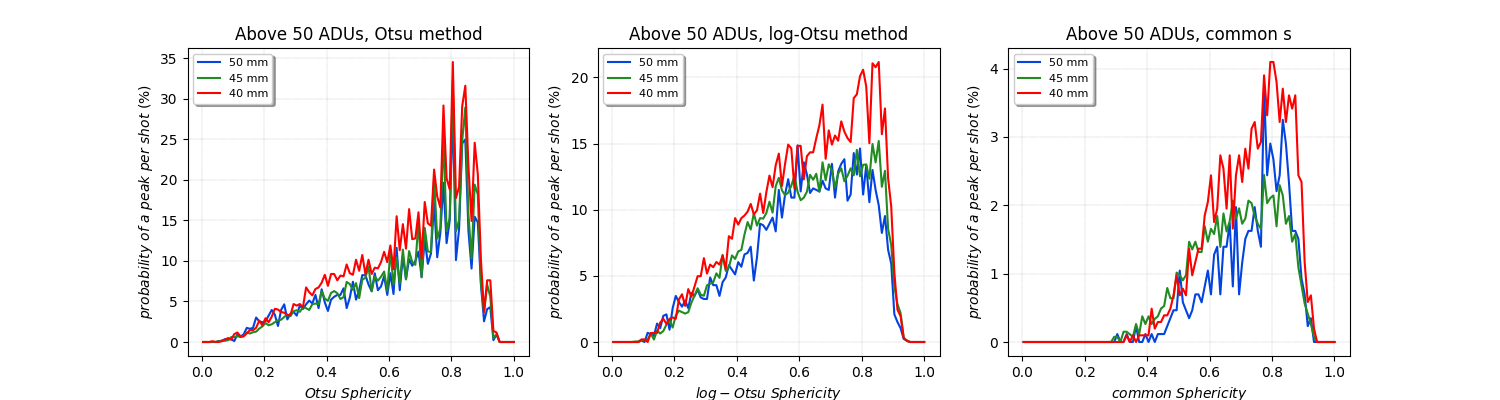

In [932]:
# sphericity Otsu vs log for all q_cm range whole dic 
fig = plt.figure(figsize = [15,4])
ax1 = fig.add_subplot(131)  # left side
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

binwidth = 0.001
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(dict_all_w_s_ots, bins=binedges)
yhist_m, bin_edges_m = np.histogram(dict_all_m_s_ots, bins=binedges)
yhist_c, bin_edges_c = np.histogram(dict_all_c_s_ots, bins=binedges)

yhist_w_log, bin_edges_w_log = np.histogram(list(filter(None, dict_all_w_s_log)), bins=binedges)
yhist_m_log, bin_edges_m_log = np.histogram(list(filter(None, dict_all_m_s_log)), bins=binedges)
yhist_c_log, bin_edges_c_log = np.histogram(list(filter(None, dict_all_c_s_log)), bins=binedges)

bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])

bin_centers1_log = np.array([(bin_edges_w_log[i] + bin_edges_w_log[i+1])/2 for i in range(len(bin_edges_w_log)-1)])
bin_centers2_log = np.array([(bin_edges_m_log[i] + bin_edges_m_log[i+1])/2 for i in range(len(bin_edges_m_log)-1)])
bin_centers3_log = np.array([(bin_edges_c_log[i] + bin_edges_c_log[i+1])/2 for i in range(len(bin_edges_c_log)-1)])

yhist_w_com, bin_edges_w_com = np.histogram(intersection_w_s_all, bins=binedges)
yhist_m_com, bin_edges_m_com = np.histogram(intersection_m_s_all, bins=binedges)
yhist_c_com, bin_edges_c_com = np.histogram(intersection_c_s_all, bins=binedges)

bin_centers1_com = np.array([(bin_edges_w_com[i] + bin_edges_w_com[i+1])/2 for i in range(len(bin_edges_w_com)-1)])
bin_centers2_com = np.array([(bin_edges_m_com[i] + bin_edges_m_com[i+1])/2 for i in range(len(bin_edges_m_com)-1)])
bin_centers3_com = np.array([(bin_edges_c_com[i] + bin_edges_c_com[i+1])/2 for i in range(len(bin_edges_c_com)-1)])


new_bins, new_s_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_s_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_s_c = downsample(bin_centers3, yhist_c, size=10)

new_bins_log, new_s_w_log = downsample(bin_centers1_log, yhist_w_log, size=10)
new_bins_log, new_s_m_log = downsample(bin_centers2_log, yhist_m_log, size=10)
new_bins_log, new_s_c_log = downsample(bin_centers3_log, yhist_c_log, size=10)

new_bins_com, new_s_w_com = downsample(bin_centers1_com, yhist_w_com, size=10)
new_bins_com, new_s_m_com = downsample(bin_centers2_com, yhist_m_com, size=10)
new_bins_com, new_s_c_com = downsample(bin_centers3_com, yhist_c_com, size=10)

T_227, = ax1.plot(new_bins, (new_s_c/pershot_dict_all_c.sum())*100, color='#0343DF')
T_228, = ax1.plot(new_bins, (new_s_m/pershot_dict_all_m.sum())*100, color='forestgreen')
T_229, = ax1.plot(new_bins, (new_s_w/pershot_dict_all_w.sum())*100, color='r')

T_227_1, = ax2.plot(new_bins_log, (new_s_c_log/pershot_dict_all_c.sum())*100, color='#0343DF')
T_228_1, = ax2.plot(new_bins_log, (new_s_m_log/pershot_dict_all_m.sum())*100, color='forestgreen')
T_229_1, = ax2.plot(new_bins_log, (new_s_w_log/pershot_dict_all_w.sum())*100, color='r')

T_227_com, = ax3.plot(new_bins_com, (new_s_c_com/pershot_dict_all_c.sum())*100, color='#0343DF')
T_228_com, = ax3.plot(new_bins_com, (new_s_m_com/pershot_dict_all_m.sum())*100, color='forestgreen')
T_229_com, = ax3.plot(new_bins_com, (new_s_w_com/pershot_dict_all_w.sum())*100, color='r')


ax1.legend(handles=[T_227, T_228, T_229], labels=['50 mm', '45 mm', '40 mm'], loc='upper left', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax1.set_xlabel('$Otsu\ Sphericity$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax1.set_ylabel('$probability\ of\ a\ peak\ per\ shot\ (\%)$')
#plt.xlim(0.65, 1.)
#ax1.set_title('Above 50 ADUs, Otsu method')
ax1.grid(c = 'grey',linestyle=':', linewidth=0.3)

ax2.legend(handles=[T_227_1, T_228_1, T_229_1], labels=['50 mm', '45 mm', '40 mm'], loc='upper left', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax2.set_xlabel('$log-Otsu\ Sphericity$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax2.set_ylabel('$probability\ of\ a\ peak\ per\ shot\ (\%)$')
#plt.xlim(0.65, 1.)
ax2.set_title('Above 50 ADUs, log-Otsu method')
ax2.grid(c = 'grey',linestyle=':', linewidth=0.3)

ax3.legend(handles=[T_227_com, T_228_com, T_229_com], labels=['50 mm', '45 mm', '40 mm'], loc='upper left', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax3.set_xlabel('$common\ Sphericity$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax3.set_ylabel('$probability\ of\ a\ peak\ per\ shot\ (\%)$')
#plt.xlim(0.65, 1.)
#ax3.set_title('Above 50 ADUs, common s')
ax3.grid(c = 'grey',linestyle=':', linewidth=0.3)

plt.savefig('/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/LCLS_plots/case1_101.eps', format='eps')
plt.show()  

<IPython.core.display.Javascript object>


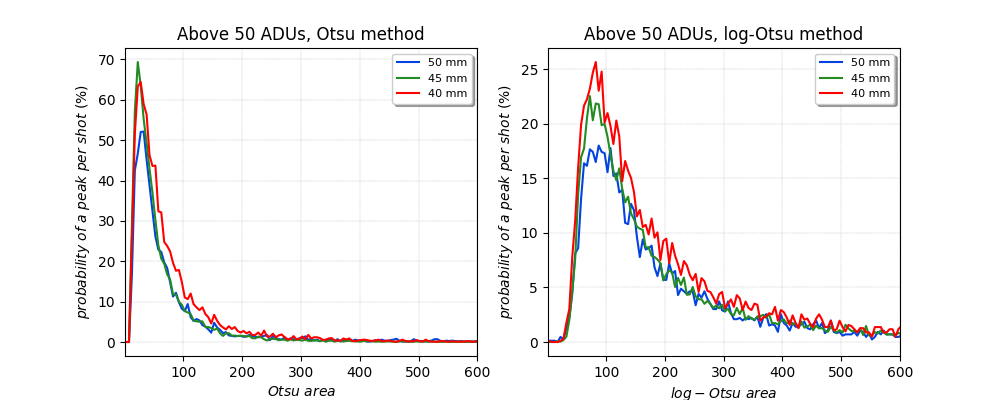

In [838]:
# area Otsu vs log for all q_cm range whole dic 
fig = plt.figure(figsize = [10,4])
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # left side
binwidth = 0.5
binedges = np.arange(0-binwidth/2,800+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(dict_all_w_a_ots, bins=binedges)
yhist_m, bin_edges_m = np.histogram(dict_all_m_a_ots, bins=binedges)
yhist_c, bin_edges_c = np.histogram(dict_all_c_a_ots, bins=binedges)

yhist_w_log, bin_edges_w_log = np.histogram(list(filter(None, dict_all_w_a_log)), bins=binedges)
yhist_m_log, bin_edges_m_log = np.histogram(list(filter(None, dict_all_m_a_log)), bins=binedges)
yhist_c_log, bin_edges_c_log = np.histogram(list(filter(None, dict_all_c_a_log)), bins=binedges)

bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])

bin_centers1_log = np.array([(bin_edges_w_log[i] + bin_edges_w_log[i+1])/2 for i in range(len(bin_edges_w_log)-1)])
bin_centers2_log = np.array([(bin_edges_m_log[i] + bin_edges_m_log[i+1])/2 for i in range(len(bin_edges_m_log)-1)])
bin_centers3_log = np.array([(bin_edges_c_log[i] + bin_edges_c_log[i+1])/2 for i in range(len(bin_edges_c_log)-1)])

new_bins, new_a_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_a_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_a_c = downsample(bin_centers3, yhist_c, size=10)

new_bins_log, new_a_w_log = downsample(bin_centers1_log, yhist_w_log, size=10)
new_bins_log, new_a_m_log = downsample(bin_centers2_log, yhist_m_log, size=10)
new_bins_log, new_a_c_log = downsample(bin_centers3_log, yhist_c_log, size=10)

T_227, = ax1.plot(new_bins, (new_a_c/pershot_dict_all_c.sum())*100, color='#0343DF')
T_228, = ax1.plot(new_bins, (new_a_m/pershot_dict_all_m.sum())*100, color='forestgreen')
T_229, = ax1.plot(new_bins, (new_a_w/pershot_dict_all_w.sum())*100, color='r')

T_227_1, = ax2.plot(new_bins, (new_a_c_log/pershot_dict_all_c.sum())*100, color='#0343DF')
T_228_1, = ax2.plot(new_bins, (new_a_m_log/pershot_dict_all_m.sum())*100, color='forestgreen')
T_229_1, = ax2.plot(new_bins, (new_a_w_log/pershot_dict_all_w.sum())*100, color='r')



ax1.legend(handles=[T_227, T_228, T_229], labels=['50 mm', '45 mm', '40 mm'], loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax1.set_xlabel('$Otsu\ area$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax1.set_ylabel('$probability\ of\ a\ peak\ per\ shot\ (\%)$')
#plt.xlim(0.65, 1.)
ax1.set_title('Above 50 ADUs, Otsu method')
ax1.grid(c = 'grey',linestyle=':', linewidth=0.3)

ax2.legend(handles=[T_227_1, T_228_1, T_229_1], labels=['50 mm', '45 mm', '40 mm'], loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax2.set_xlabel('$log-Otsu\ area$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax2.set_ylabel('$probability\ of\ a\ peak\ per\ shot\ (\%)$')
ax1.set_xlim(0.5, 600)
ax2.set_xlim(0.5, 600)
ax2.set_title('Above 50 ADUs, log-Otsu method')
ax2.grid(c = 'grey',linestyle=':', linewidth=0.3)

plt.savefig('/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/LCLS_plots/case1_101.eps', format='eps')
plt.show()  

<IPython.core.display.Javascript object>


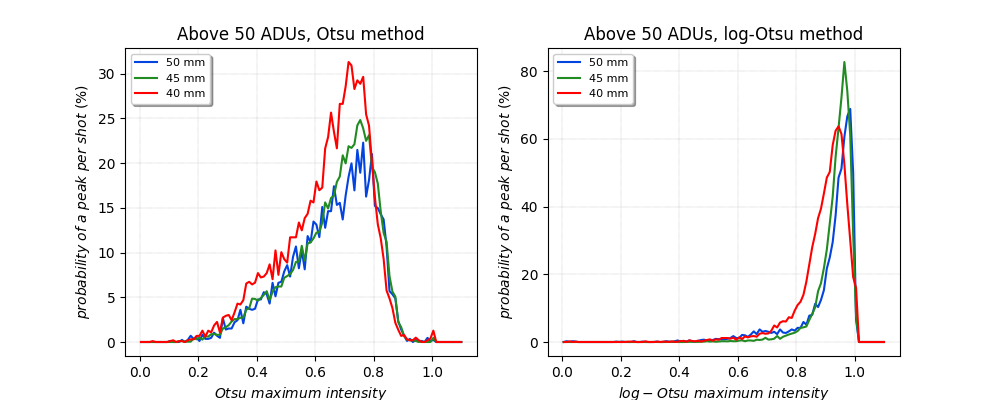

In [878]:
# max I with Otsu vs log for all q_cm range whole dic 
fig = plt.figure(figsize = [10,4])
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # left side
binwidth = 0.001
binedges = np.arange(0-binwidth/2,1.1+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(dict_all_w_i_ots, bins=binedges)
yhist_m, bin_edges_m = np.histogram(dict_all_m_i_ots, bins=binedges)
yhist_c, bin_edges_c = np.histogram(dict_all_c_i_ots, bins=binedges)

yhist_w_log, bin_edges_w_log = np.histogram(list(filter(None, dict_all_w_i_log)), bins=binedges)
yhist_m_log, bin_edges_m_log = np.histogram(list(filter(None, dict_all_m_i_log)), bins=binedges)
yhist_c_log, bin_edges_c_log = np.histogram(list(filter(None, dict_all_c_i_log)), bins=binedges)

bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])

bin_centers1_log = np.array([(bin_edges_w_log[i] + bin_edges_w_log[i+1])/2 for i in range(len(bin_edges_w_log)-1)])
bin_centers2_log = np.array([(bin_edges_m_log[i] + bin_edges_m_log[i+1])/2 for i in range(len(bin_edges_m_log)-1)])
bin_centers3_log = np.array([(bin_edges_c_log[i] + bin_edges_c_log[i+1])/2 for i in range(len(bin_edges_c_log)-1)])

new_bins, new_i_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_i_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_i_c = downsample(bin_centers3, yhist_c, size=10)

new_bins_log, new_i_w_log = downsample(bin_centers1_log, yhist_w_log, size=10)
new_bins_log, new_i_m_log = downsample(bin_centers2_log, yhist_m_log, size=10)
new_bins_log, new_i_c_log = downsample(bin_centers3_log, yhist_c_log, size=10)

T_227, = ax1.plot(new_bins, (new_i_c/pershot_dict_all_c.sum())*100, color='#0343DF')
T_228, = ax1.plot(new_bins, (new_i_m/pershot_dict_all_m.sum())*100, color='forestgreen')
T_229, = ax1.plot(new_bins, (new_i_w/pershot_dict_all_w.sum())*100, color='r')

T_227_1, = ax2.plot(new_bins, (new_i_c_log/pershot_dict_all_c.sum())*100, color='#0343DF')
T_228_1, = ax2.plot(new_bins, (new_i_m_log/pershot_dict_all_m.sum())*100, color='forestgreen')
T_229_1, = ax2.plot(new_bins, (new_i_w_log/pershot_dict_all_w.sum())*100, color='r')



ax1.legend(handles=[T_227, T_228, T_229], labels=['50 mm', '45 mm', '40 mm'], loc='upper left', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax1.set_xlabel('$Otsu\ maximum\ intensity$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax1.set_ylabel('$probability\ of\ a\ peak\ per\ shot\ (\%)$')
#plt.xlim(0.65, 1.)
ax1.set_title('Above 50 ADUs, Otsu method')
ax1.grid(c = 'grey',linestyle=':', linewidth=0.3)

ax2.legend(handles=[T_227_1, T_228_1, T_229_1], labels=['50 mm', '45 mm', '40 mm'], loc='upper left', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax2.set_xlabel('$log-Otsu\ maximum\ intensity$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax2.set_ylabel('$probability\ of\ a\ peak\ per\ shot\ (\%)$')
#ax1.set_xlim(0.5, 600)
#ax2.set_xlim(0.5, 600)
ax2.set_title('Above 50 ADUs, log-Otsu method')
ax2.grid(c = 'grey',linestyle=':', linewidth=0.3)

plt.savefig('/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/LCLS_plots/case1_101.eps', format='eps')
plt.show()  

In [857]:
# area with different methods 
dict_all_w_d_min = [list(d_values(dict_all_w, 3))[x]['min_distance'] for x in range(len(list(d_values(dict_all_w, 3))))]
dict_all_m_d_min = [list(d_values(dict_all_m, 3))[x]['min_distance'] for x in range(len(list(d_values(dict_all_m, 3))))]
dict_all_c_d_min = [list(d_values(dict_all_c, 3))[x]['min_distance'] for x in range(len(list(d_values(dict_all_c, 3))))]

dict_all_w_d = [list(d_values(dict_all_w, 3))[x]['all_distances'] for x in range(len(list(d_values(dict_all_w, 3))))]
dict_all_m_d = [list(d_values(dict_all_m, 3))[x]['all_distances'] for x in range(len(list(d_values(dict_all_m, 3))))]
dict_all_c_d = [list(d_values(dict_all_c, 3))[x]['all_distances'] for x in range(len(list(d_values(dict_all_c, 3))))]

<IPython.core.display.Javascript object>


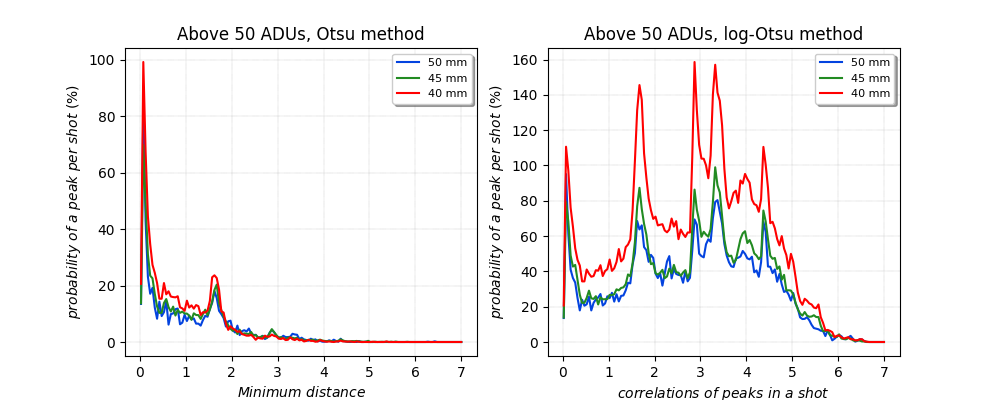

In [868]:
# min_d and d with Otsu vs log for all q_cm range whole dic 
fig = plt.figure(figsize = [10,4])
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # left side
binwidth = 0.005
binedges = np.arange(0-binwidth/2,7.+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(dict_all_w_d_min, bins=binedges)
yhist_m, bin_edges_m = np.histogram(dict_all_m_d_min, bins=binedges)
yhist_c, bin_edges_c = np.histogram(dict_all_c_d_min, bins=binedges)

yhist_w_log, bin_edges_w_log = np.histogram(np.concatenate(dict_all_w_d), bins=binedges)
yhist_m_log, bin_edges_m_log = np.histogram(np.concatenate(dict_all_m_d), bins=binedges)
yhist_c_log, bin_edges_c_log = np.histogram(np.concatenate(dict_all_c_d), bins=binedges)

bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])

bin_centers1_log = np.array([(bin_edges_w_log[i] + bin_edges_w_log[i+1])/2 for i in range(len(bin_edges_w_log)-1)])
bin_centers2_log = np.array([(bin_edges_m_log[i] + bin_edges_m_log[i+1])/2 for i in range(len(bin_edges_m_log)-1)])
bin_centers3_log = np.array([(bin_edges_c_log[i] + bin_edges_c_log[i+1])/2 for i in range(len(bin_edges_c_log)-1)])

new_bins, new_d_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_d_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_d_c = downsample(bin_centers3, yhist_c, size=10)

new_bins_log, new_d_w_min = downsample(bin_centers1_log, yhist_w_log, size=10)
new_bins_log, new_d_m_min = downsample(bin_centers2_log, yhist_m_log, size=10)
new_bins_log, new_d_c_min = downsample(bin_centers3_log, yhist_c_log, size=10)

T_227, = ax1.plot(new_bins, (new_d_c/pershot_dict_all_c.sum())*100, color='#0343DF')
T_228, = ax1.plot(new_bins, (new_d_m/pershot_dict_all_m.sum())*100, color='forestgreen')
T_229, = ax1.plot(new_bins, (new_d_w/pershot_dict_all_w.sum())*100, color='r')

T_227_1, = ax2.plot(new_bins, (new_d_c_min/pershot_dict_all_c.sum())*100, color='#0343DF')
T_228_1, = ax2.plot(new_bins, (new_d_m_min/pershot_dict_all_m.sum())*100, color='forestgreen')
T_229_1, = ax2.plot(new_bins, (new_d_w_min/pershot_dict_all_w.sum())*100, color='r')



ax1.legend(handles=[T_227, T_228, T_229], labels=['50 mm', '45 mm', '40 mm'], loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax1.set_xlabel('$Minimum\ distance$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax1.set_ylabel('$probability\ of\ a\ peak\ per\ shot\ (\%)$')
#plt.xlim(0.65, 1.)
ax1.set_title('Above 50 ADUs, Otsu method')
ax1.grid(c = 'grey',linestyle=':', linewidth=0.3)

ax2.legend(handles=[T_227_1, T_228_1, T_229_1], labels=['50 mm', '45 mm', '40 mm'], loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax2.set_xlabel('$correlations\ of\ peaks\ in\ a\ shot$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax2.set_ylabel('$probability\ of\ a\ peak\ per\ shot\ (\%)$')
#ax1.set_xlim(0.5, 600)
#ax2.set_xlim(0.5, 600)
ax2.set_title('Above 50 ADUs, log-Otsu method')
ax2.grid(c = 'grey',linestyle=':', linewidth=0.3)

plt.savefig('/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/LCLS_plots/case1_101.eps', format='eps')
plt.show()  

In [35]:
# case 1 sphericity plots different methods
aw = [list(dict_case1_c[run].keys()) for run in T_c]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_dict_case1_c = np.array([len([s for s in fg if n in s]) for n in T_c])

In [36]:
# case 1 sphericity plots different methods
aw = [list(dict_case1_w[run].keys()) for run in T_w]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_dict_case1_w = np.array([len([s for s in fg if n in s]) for n in T_w])

In [37]:
# case 1 sphericity plots different methods
aw = [list(dict_case1_m[run].keys()) for run in T_m]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_dict_case1_m = np.array([len([s for s in fg if n in s]) for n in T_m])

In [969]:
# sphericity with different methods
#dict_case1_w_s_ots = [list(d_values(dict_case1_w, 3))[x]['Otsu_sphericity'] for x in range(len(list(d_values(dict_case1_w, 3))))]
#dict_case1_m_s_ots = [list(d_values(dict_case1_m, 3))[x]['Otsu_sphericity'] for x in range(len(list(d_values(dict_case1_m, 3))))]
#dict_case1_c_s_ots = [list(d_values(dict_case1_c, 3))[x]['Otsu_sphericity'] for x in range(len(list(d_values(dict_case1_c, 3))))]

dict_case1_w_s_log = filterTheDict_case1(dict_all_w, 0.7, 1.1, 0.2, 9)
dict_case1_m_s_log = filterTheDict_case1(dict_all_m, 0.7, 1.1, 0.2, 9)
dict_case1_c_s_log = filterTheDict_case1(dict_all_c, 0.7, 1.1, 0.2, 9)


TypeError: '>=' not supported between instances of 'NoneType' and 'float'

In [56]:
dict_case1_w_s_ots = [list(d_values(dict_case1_w, 3))[x]['Otsu_sphericity'] for x in range(len(list(d_values(dict_case1_w, 3))))]
dict_case1_m_s_ots = [list(d_values(dict_case1_m, 3))[x]['Otsu_sphericity'] for x in range(len(list(d_values(dict_case1_m, 3))))]
dict_case1_c_s_ots = [list(d_values(dict_case1_c, 3))[x]['Otsu_sphericity'] for x in range(len(list(d_values(dict_case1_c, 3))))]


In [57]:
dict_case1_w_s_log = [list(d_values(dict_case1_w, 3))[x]['log-Otsu_sphericity'] for x in range(len(list(d_values(dict_case1_w, 3))))]
dict_case1_m_s_log = [list(d_values(dict_case1_m, 3))[x]['log-Otsu_sphericity'] for x in range(len(list(d_values(dict_case1_m, 3))))]
dict_case1_c_s_log = [list(d_values(dict_case1_c, 3))[x]['log-Otsu_sphericity'] for x in range(len(list(d_values(dict_case1_c, 3))))]


In [62]:
len(dict_case1_m_s_ots),len(dict_case1_m_s_log)

(6399, 6399)

In [ ]:
dict_case1_w_s_log

<IPython.core.display.Javascript object>


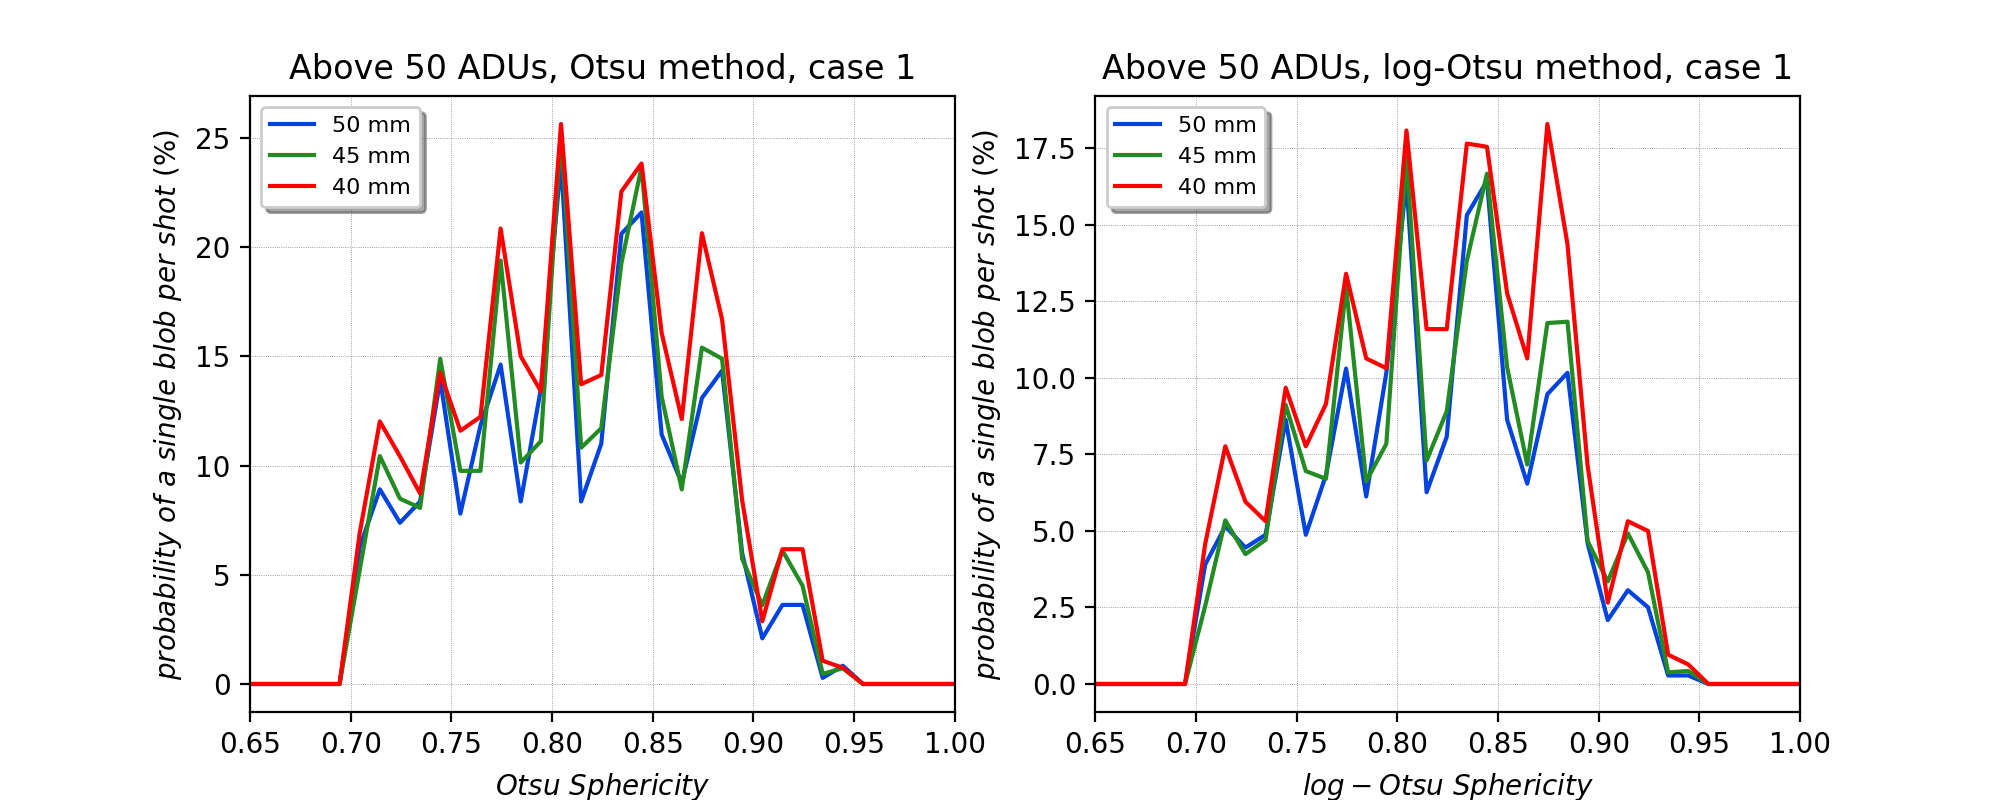

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [52]:
# sphericity Otsu vs log for case1 
fig = plt.figure(figsize = [10,4])
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # left side
binwidth = 0.001
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(dict_case1_w_s_ots, bins=binedges)
yhist_m, bin_edges_m = np.histogram(dict_case1_m_s_ots, bins=binedges)
yhist_c, bin_edges_c = np.histogram(dict_case1_c_s_ots, bins=binedges)

yhist_w_log, bin_edges_w_log = np.histogram(list(filter(None, dict_case1_w_s_log)), bins=binedges)
yhist_m_log, bin_edges_m_log = np.histogram(list(filter(None, dict_case1_m_s_log)), bins=binedges)
yhist_c_log, bin_edges_c_log = np.histogram(list(filter(None, dict_case1_c_s_log)), bins=binedges)

bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])

bin_centers1_log = np.array([(bin_edges_w_log[i] + bin_edges_w_log[i+1])/2 for i in range(len(bin_edges_w_log)-1)])
bin_centers2_log = np.array([(bin_edges_m_log[i] + bin_edges_m_log[i+1])/2 for i in range(len(bin_edges_m_log)-1)])
bin_centers3_log = np.array([(bin_edges_c_log[i] + bin_edges_c_log[i+1])/2 for i in range(len(bin_edges_c_log)-1)])

new_bins, new_s_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_s_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_s_c = downsample(bin_centers3, yhist_c, size=10)

new_bins_log, new_s_w_log = downsample(bin_centers1_log, yhist_w_log, size=10)
new_bins_log, new_s_m_log = downsample(bin_centers2_log, yhist_m_log, size=10)
new_bins_log, new_s_c_log = downsample(bin_centers3_log, yhist_c_log, size=10)

T_227, = ax1.plot(new_bins, (new_s_c/pershot_dict_case1_c.sum())*100, color='#0343DF')
T_228, = ax1.plot(new_bins, (new_s_m/pershot_dict_case1_m.sum())*100, color='forestgreen')
T_229, = ax1.plot(new_bins, (new_s_w/pershot_dict_case1_w.sum())*100, color='r')

T_227_1, = ax2.plot(new_bins, (new_s_c_log/pershot_dict_case1_c.sum())*100, color='#0343DF')
T_228_1, = ax2.plot(new_bins, (new_s_m_log/pershot_dict_case1_m.sum())*100, color='forestgreen')
T_229_1, = ax2.plot(new_bins, (new_s_w_log/pershot_dict_case1_w.sum())*100, color='r')



ax1.legend(handles=[T_227, T_228, T_229], labels=['50 mm', '45 mm', '40 mm'], loc='upper left', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax1.set_xlabel('$Otsu\ Sphericity$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax1.set_ylabel('$probability\ of\ a\ single\ blob\ per\ shot\ (\%)$')
#plt.xlim(0.65, 1.)
ax1.set_title('Above 50 ADUs, Otsu method, case 1')
ax1.grid(c = 'grey',linestyle=':', linewidth=0.3)

ax2.legend(handles=[T_227_1, T_228_1, T_229_1], labels=['50 mm', '45 mm', '40 mm'], loc='upper left', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax2.set_xlabel('$log-Otsu\ Sphericity$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax2.set_ylabel('$probability\ of\ a\ single\ blob\ per\ shot\ (\%)$')
ax1.set_xlim(0.65, 1.)
ax2.set_xlim(0.65, 1.)
ax2.set_title('Above 50 ADUs, log-Otsu method, case 1')
ax2.grid(c = 'grey',linestyle=':', linewidth=0.3)

plt.savefig('/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/LCLS_plots/case1_101.eps', format='eps')
plt.show()  

In [55]:
len(dict_case1_m_s_ots)-len(dict_case1_m_s_log)

1931

In [48]:
dict_case1_m_s_log = [dict_case1_m_s_ots[x] for x in np.where(np.array(dict_case1_m_s_log) > 0.7)[0]]
dict_case1_w_s_log = [dict_case1_w_s_ots[x] for x in np.where(np.array(dict_case1_w_s_log) > 0.7)[0]]
dict_case1_c_s_log = [dict_case1_c_s_ots[x] for x in np.where(np.array(dict_case1_c_s_log) > 0.7)[0]]

In [876]:
# area with different methods 
dict_case1_w_a_ots = [list(d_values(dict_case1_w, 3))[x]['Otsu_area'] for x in range(len(list(d_values(dict_case1_w, 3))))]
dict_case1_m_a_ots = [list(d_values(dict_case1_m, 3))[x]['Otsu_area'] for x in range(len(list(d_values(dict_case1_m, 3))))]
dict_case1_c_a_ots = [list(d_values(dict_case1_c, 3))[x]['Otsu_area'] for x in range(len(list(d_values(dict_case1_c, 3))))]

dict_case1_w_a_log = [list(d_values(dict_case1_w, 3))[x]['log-Otsu_area'] for x in range(len(list(d_values(dict_case1_w, 3))))]
dict_case1_m_a_log = [list(d_values(dict_case1_m, 3))[x]['log-Otsu_area'] for x in range(len(list(d_values(dict_case1_m, 3))))]
dict_case1_c_a_log = [list(d_values(dict_case1_c, 3))[x]['log-Otsu_area'] for x in range(len(list(d_values(dict_case1_c, 3))))]


<IPython.core.display.Javascript object>


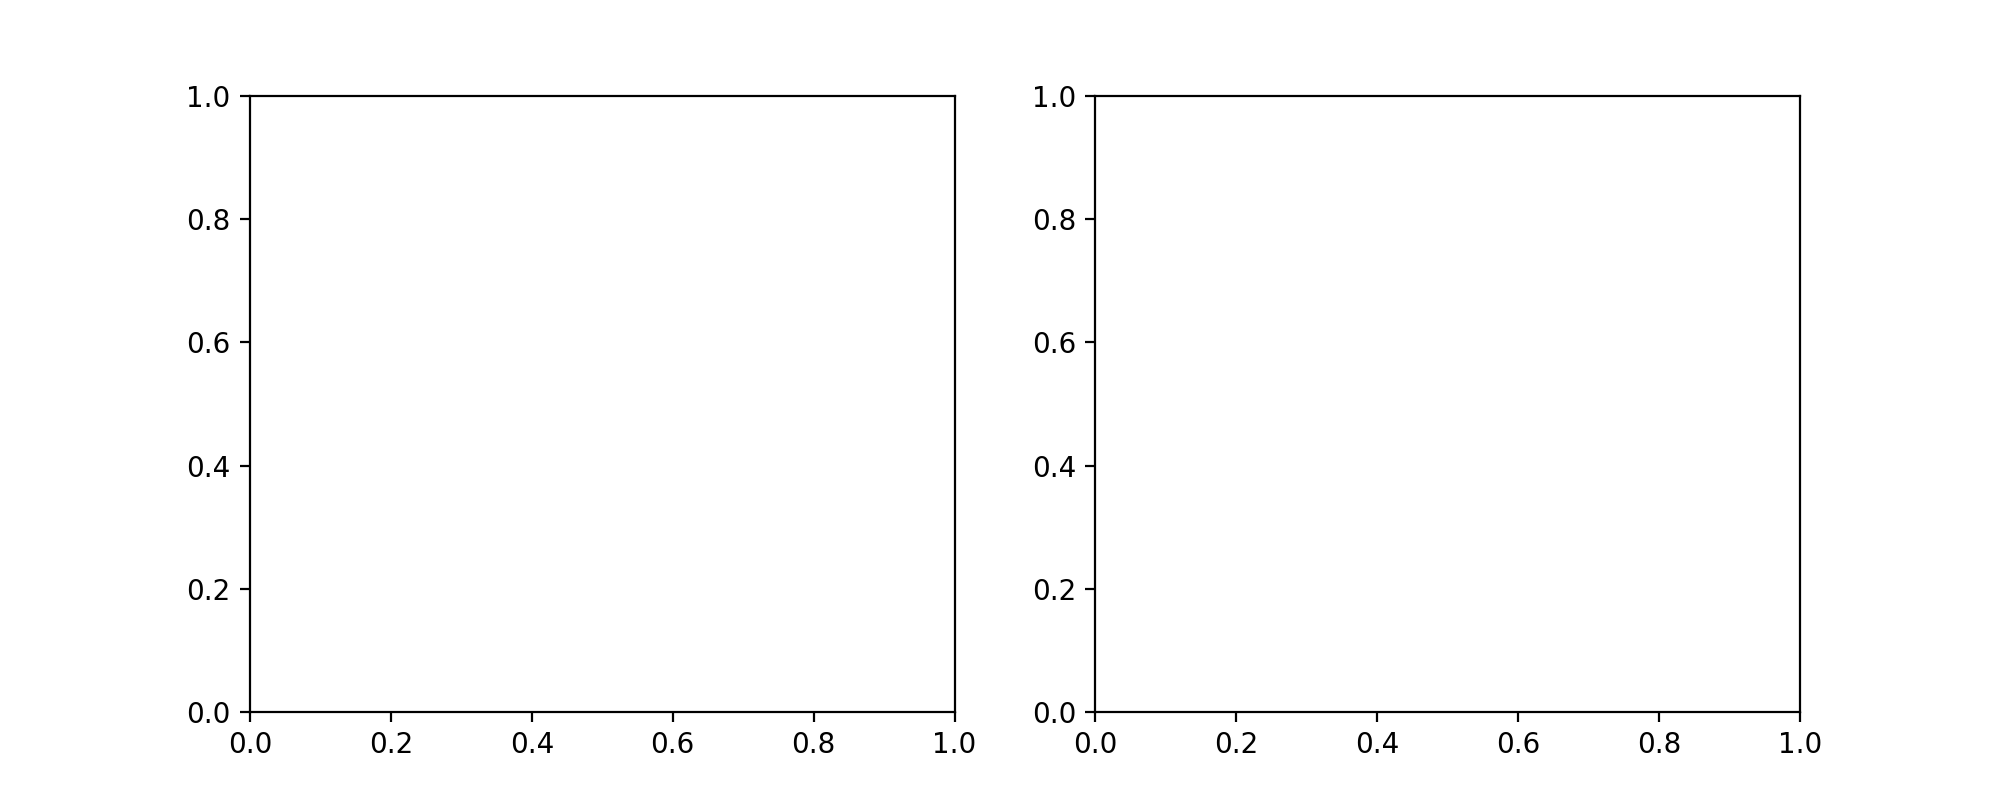

NameError: name 'dict_case1_w_a_ots' is not defined

In [49]:
# area Otsu vs log for case1 
fig = plt.figure(figsize = [10,4])
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # left side
binwidth = 0.5
binedges = np.arange(0-binwidth/2,800+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(dict_case1_w_a_ots, bins=binedges)
yhist_m, bin_edges_m = np.histogram(dict_case1_m_a_ots, bins=binedges)
yhist_c, bin_edges_c = np.histogram(dict_case1_c_a_ots, bins=binedges)

yhist_w_log, bin_edges_w_log = np.histogram(list(filter(None, dict_case1_w_a_log)), bins=binedges)
yhist_m_log, bin_edges_m_log = np.histogram(list(filter(None, dict_case1_m_a_log)), bins=binedges)
yhist_c_log, bin_edges_c_log = np.histogram(list(filter(None, dict_case1_c_a_log)), bins=binedges)

bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])

bin_centers1_log = np.array([(bin_edges_w_log[i] + bin_edges_w_log[i+1])/2 for i in range(len(bin_edges_w_log)-1)])
bin_centers2_log = np.array([(bin_edges_m_log[i] + bin_edges_m_log[i+1])/2 for i in range(len(bin_edges_m_log)-1)])
bin_centers3_log = np.array([(bin_edges_c_log[i] + bin_edges_c_log[i+1])/2 for i in range(len(bin_edges_c_log)-1)])

new_bins, new_s_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_s_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_s_c = downsample(bin_centers3, yhist_c, size=10)

new_bins_log, new_s_w_log = downsample(bin_centers1_log, yhist_w_log, size=10)
new_bins_log, new_s_m_log = downsample(bin_centers2_log, yhist_m_log, size=10)
new_bins_log, new_s_c_log = downsample(bin_centers3_log, yhist_c_log, size=10)

T_227, = ax1.plot(new_bins, (new_s_c/pershot_dict_case1_c.sum())*100, color='#0343DF')
T_228, = ax1.plot(new_bins, (new_s_m/pershot_dict_case1_m.sum())*100, color='forestgreen')
T_229, = ax1.plot(new_bins, (new_s_w/pershot_dict_case1_w.sum())*100, color='r')

T_227_1, = ax2.plot(new_bins, (new_s_c_log/pershot_dict_case1_c.sum())*100, color='#0343DF')
T_228_1, = ax2.plot(new_bins, (new_s_m_log/pershot_dict_case1_m.sum())*100, color='forestgreen')
T_229_1, = ax2.plot(new_bins, (new_s_w_log/pershot_dict_case1_w.sum())*100, color='r')



ax1.legend(handles=[T_227, T_228, T_229], labels=['50 mm', '45 mm', '40 mm'], loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax1.set_xlabel('$Otsu\ area$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax1.set_ylabel('$probability\ of\ a\ single\ blob\ per\ shot\ (\%)$')
#plt.xlim(0.65, 1.)
ax1.set_title('Above 50 ADUs, Otsu method, case 1')
ax1.grid(c = 'grey',linestyle=':', linewidth=0.3)

ax2.legend(handles=[T_227_1, T_228_1, T_229_1], labels=['50 mm', '45 mm', '40 mm'], loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax2.set_xlabel('$log-Otsu\ area$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax2.set_ylabel('$probability\ of\ a\ single\ blob\ per\ shot\ (\%)$')
#ax1.set_xlim(0.65, 1.)
ax2.set_title('Above 50 ADUs, log-Otsu method, case 1')
ax2.grid(c = 'grey',linestyle=':', linewidth=0.3)

plt.savefig('/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/LCLS_plots/case1_101.eps', format='eps')
plt.show()  

In [881]:
# intensity with different methods 
dict_case1_w_i_ots = [list(d_values(dict_case1_w, 3))[x]['Otsu_max_intensity'] for x in range(len(list(d_values(dict_case1_w, 3))))]
dict_case1_m_i_ots = [list(d_values(dict_case1_m, 3))[x]['Otsu_max_intensity'] for x in range(len(list(d_values(dict_case1_m, 3))))]
dict_case1_c_i_ots = [list(d_values(dict_case1_c, 3))[x]['Otsu_max_intensity'] for x in range(len(list(d_values(dict_case1_c, 3))))]

dict_case1_w_i_log = [list(d_values(dict_case1_w, 3))[x]['log-Otsu_max_intensity'] for x in range(len(list(d_values(dict_case1_w, 3))))]
dict_case1_m_i_log = [list(d_values(dict_case1_m, 3))[x]['log-Otsu_max_intensity'] for x in range(len(list(d_values(dict_case1_m, 3))))]
dict_case1_c_i_log = [list(d_values(dict_case1_c, 3))[x]['log-Otsu_max_intensity'] for x in range(len(list(d_values(dict_case1_c, 3))))]

<IPython.core.display.Javascript object>


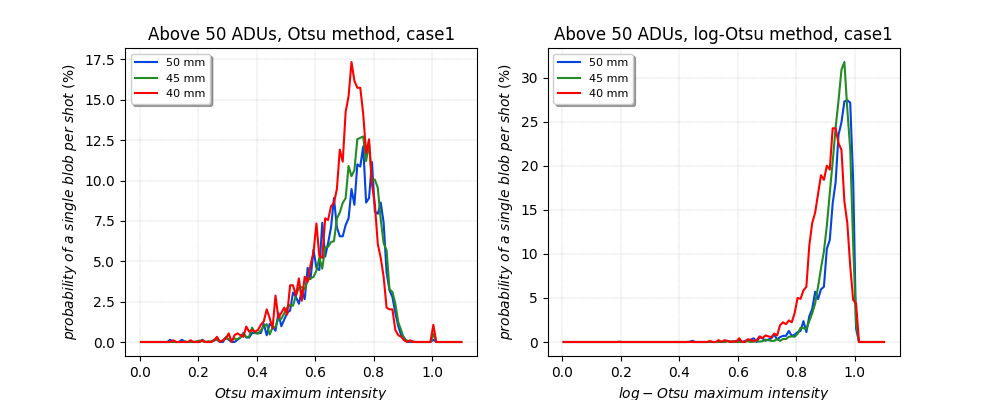

In [883]:
# I Otsu vs log for case1 
fig = plt.figure(figsize = [10,4])
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # left side
binwidth = 0.001
binedges = np.arange(0-binwidth/2,1.1+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(dict_case1_w_i_ots, bins=binedges)
yhist_m, bin_edges_m = np.histogram(dict_case1_m_i_ots, bins=binedges)
yhist_c, bin_edges_c = np.histogram(dict_case1_c_i_ots, bins=binedges)

yhist_w_log, bin_edges_w_log = np.histogram(list(filter(None, dict_case1_w_i_log)), bins=binedges)
yhist_m_log, bin_edges_m_log = np.histogram(list(filter(None, dict_case1_m_i_log)), bins=binedges)
yhist_c_log, bin_edges_c_log = np.histogram(list(filter(None, dict_case1_c_i_log)), bins=binedges)

bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])

bin_centers1_log = np.array([(bin_edges_w_log[i] + bin_edges_w_log[i+1])/2 for i in range(len(bin_edges_w_log)-1)])
bin_centers2_log = np.array([(bin_edges_m_log[i] + bin_edges_m_log[i+1])/2 for i in range(len(bin_edges_m_log)-1)])
bin_centers3_log = np.array([(bin_edges_c_log[i] + bin_edges_c_log[i+1])/2 for i in range(len(bin_edges_c_log)-1)])

new_bins, new_s_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_s_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_s_c = downsample(bin_centers3, yhist_c, size=10)

new_bins_log, new_s_w_log = downsample(bin_centers1_log, yhist_w_log, size=10)
new_bins_log, new_s_m_log = downsample(bin_centers2_log, yhist_m_log, size=10)
new_bins_log, new_s_c_log = downsample(bin_centers3_log, yhist_c_log, size=10)

T_227, = ax1.plot(new_bins, (new_s_c/pershot_dict_case1_c.sum())*100, color='#0343DF')
T_228, = ax1.plot(new_bins, (new_s_m/pershot_dict_case1_m.sum())*100, color='forestgreen')
T_229, = ax1.plot(new_bins, (new_s_w/pershot_dict_case1_w.sum())*100, color='r')

T_227_1, = ax2.plot(new_bins, (new_s_c_log/pershot_dict_case1_c.sum())*100, color='#0343DF')
T_228_1, = ax2.plot(new_bins, (new_s_m_log/pershot_dict_case1_m.sum())*100, color='forestgreen')
T_229_1, = ax2.plot(new_bins, (new_s_w_log/pershot_dict_case1_w.sum())*100, color='r')

ax1.legend(handles=[T_227, T_228, T_229], labels=['50 mm', '45 mm', '40 mm'], loc='upper left', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax1.set_xlabel('$Otsu\ maximum\ intensity$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax1.set_ylabel('$probability\ of\ a\ single\ blob\ per\ shot\ (\%)$')
#plt.xlim(0.65, 1.)
ax1.set_title('Above 50 ADUs, Otsu method, case1')
ax1.grid(c = 'grey',linestyle=':', linewidth=0.3)

ax2.legend(handles=[T_227_1, T_228_1, T_229_1], labels=['50 mm', '45 mm', '40 mm'], loc='upper left', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax2.set_xlabel('$log-Otsu\ maximum\ intensity$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax2.set_ylabel('$probability\ of\ a\ single\ blob\ per\ shot\ (\%)$')
#ax1.set_xlim(0.5, 600)
#ax2.set_xlim(0.5, 600)
ax2.set_title('Above 50 ADUs, log-Otsu method, case1')
ax2.grid(c = 'grey',linestyle=':', linewidth=0.3)

plt.savefig('/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/LCLS_plots/case1_101.eps', format='eps')
plt.show()  


In [884]:
# d with different methods 
dict_case1_w_d_min = [list(d_values(dict_case1_w, 3))[x]['min_distance'] for x in range(len(list(d_values(dict_case1_w, 3))))]
dict_case1_m_d_min = [list(d_values(dict_case1_m, 3))[x]['min_distance'] for x in range(len(list(d_values(dict_case1_m, 3))))]
dict_case1_c_d_min = [list(d_values(dict_case1_c, 3))[x]['min_distance'] for x in range(len(list(d_values(dict_case1_c, 3))))]

dict_case1_w_d = [list(d_values(dict_case1_w, 3))[x]['all_distances'] for x in range(len(list(d_values(dict_case1_w, 3))))]
dict_case1_m_d = [list(d_values(dict_case1_m, 3))[x]['all_distances'] for x in range(len(list(d_values(dict_case1_m, 3))))]
dict_case1_c_d = [list(d_values(dict_case1_c, 3))[x]['all_distances'] for x in range(len(list(d_values(dict_case1_c, 3))))]

<IPython.core.display.Javascript object>


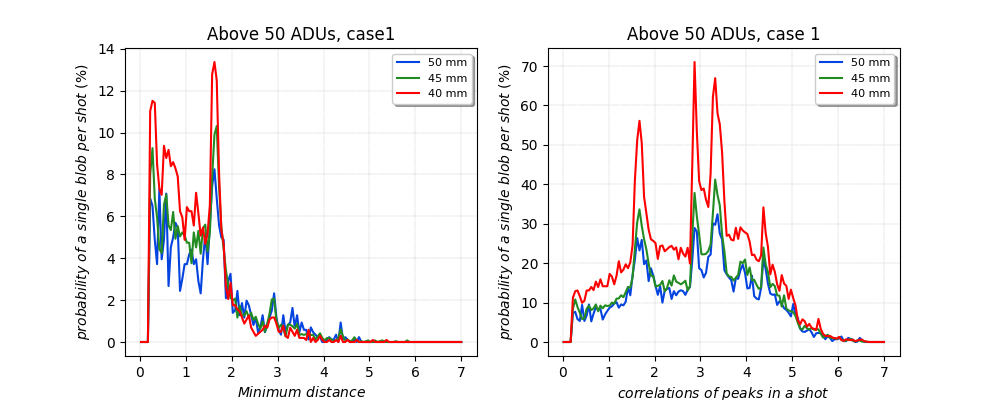

In [918]:
# min_d and d with Otsu vs log for all q_cm range whole dic 
fig = plt.figure(figsize = [10,4])
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # left side
binwidth = 0.005
binedges = np.arange(0-binwidth/2,7.+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(dict_case1_w_d_min, bins=binedges)
yhist_m, bin_edges_m = np.histogram(dict_case1_m_d_min, bins=binedges)
yhist_c, bin_edges_c = np.histogram(dict_case1_c_d_min, bins=binedges)

yhist_w_log, bin_edges_w_log = np.histogram(np.concatenate(dict_case1_w_d), bins=binedges)
yhist_m_log, bin_edges_m_log = np.histogram(np.concatenate(dict_case1_m_d), bins=binedges)
yhist_c_log, bin_edges_c_log = np.histogram(np.concatenate(dict_case1_c_d), bins=binedges)

bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])

bin_centers1_log = np.array([(bin_edges_w_log[i] + bin_edges_w_log[i+1])/2 for i in range(len(bin_edges_w_log)-1)])
bin_centers2_log = np.array([(bin_edges_m_log[i] + bin_edges_m_log[i+1])/2 for i in range(len(bin_edges_m_log)-1)])
bin_centers3_log = np.array([(bin_edges_c_log[i] + bin_edges_c_log[i+1])/2 for i in range(len(bin_edges_c_log)-1)])

new_bins, new_d_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_d_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_d_c = downsample(bin_centers3, yhist_c, size=10)

new_bins_log, new_d_w_min = downsample(bin_centers1_log, yhist_w_log, size=10)
new_bins_log, new_d_m_min = downsample(bin_centers2_log, yhist_m_log, size=10)
new_bins_log, new_d_c_min = downsample(bin_centers3_log, yhist_c_log, size=10)

T_227, = ax1.plot(new_bins, (new_d_c/pershot_dict_all_c.sum())*100, color='#0343DF')
T_228, = ax1.plot(new_bins, (new_d_m/pershot_dict_all_m.sum())*100, color='forestgreen')
T_229, = ax1.plot(new_bins, (new_d_w/pershot_dict_all_w.sum())*100, color='r')

T_227_1, = ax2.plot(new_bins, (new_d_c_min/pershot_dict_all_c.sum())*100, color='#0343DF')
T_228_1, = ax2.plot(new_bins, (new_d_m_min/pershot_dict_all_m.sum())*100, color='forestgreen')
T_229_1, = ax2.plot(new_bins, (new_d_w_min/pershot_dict_all_w.sum())*100, color='r')



ax1.legend(handles=[T_227, T_228, T_229], labels=['50 mm', '45 mm', '40 mm'], loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax1.set_xlabel('$Minimum\ distance$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax1.set_ylabel('$probability\ of\ a\ single\ blob\ per\ shot\ (\%)$')
#plt.xlim(0.65, 1.)
ax1.set_title('Above 50 ADUs, case1')
ax1.grid(c = 'grey',linestyle=':', linewidth=0.3)

ax2.legend(handles=[T_227_1, T_228_1, T_229_1], labels=['50 mm', '45 mm', '40 mm'], loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax2.set_xlabel('$correlations\ of\ peaks\ in\ a\ shot$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax2.set_ylabel('$probability\ of\ a\ single\ blob\ per\ shot\ (\%)$')
#ax1.set_xlim(0.5, 600)
#ax2.set_xlim(0.5, 600)
ax2.set_title('Above 50 ADUs, case 1')
ax2.grid(c = 'grey',linestyle=':', linewidth=0.3)

plt.savefig('/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/LCLS_plots/case1_101.eps', format='eps')
plt.show()  

In [888]:
def filterTheDict_q(input_dict, q_min_thr, q_max_thr):
    newDict ={}
    for run in input_dict.keys():
        newDict[run] ={}
        for shot in input_dict[run]:
            newDict[run][shot] ={}
            for peak in input_dict[run][shot]:
                if ((input_dict[run][shot][peak]['q_cm'] >= q_min_thr) & (input_dict[run][shot][peak]['q_cm'] < q_max_thr)):
                    newDict[run][shot][peak] = {}
                    newDict[run][shot][peak] = input_dict[run][shot][peak]
    return newDict

In [893]:
min_bound = iceIh_peaks()[0]-0.05
max_bound = iceIh_peaks()[0]+0.05
dict_all_c_100 = filterTheDict_q(dict_all_c, min_bound, max_bound)
dict_all_m_100 = filterTheDict_q(dict_all_m, min_bound, max_bound)
dict_all_w_100 = filterTheDict_q(dict_all_w, min_bound, max_bound)

# sphericity with different methods
dict_all_w_s_ots_100 = [list(d_values(dict_all_w_100, 3))[x]['Otsu_sphericity'] for x in range(len(list(d_values(dict_all_c_100, 3))))]
dict_all_m_s_ots_100 = [list(d_values(dict_all_m_100, 3))[x]['Otsu_sphericity'] for x in range(len(list(d_values(dict_all_m_100, 3))))]
dict_all_c_s_ots_100 = [list(d_values(dict_all_c_100, 3))[x]['Otsu_sphericity'] for x in range(len(list(d_values(dict_all_c_100, 3))))]

dict_all_w_s_log_100 = [list(d_values(dict_all_w_100, 3))[x]['log-Otsu_sphericity'] for x in range(len(list(d_values(dict_all_w_100, 3))))]
dict_all_m_s_log_100 = [list(d_values(dict_all_m_100, 3))[x]['log-Otsu_sphericity'] for x in range(len(list(d_values(dict_all_m_100, 3))))]
dict_all_c_s_log_100 = [list(d_values(dict_all_c_100, 3))[x]['log-Otsu_sphericity'] for x in range(len(list(d_values(dict_all_c_100, 3))))]

In [894]:
# sphericity with different methods
dict_all_w_a_ots_100 = [list(d_values(dict_all_w_100, 3))[x]['Otsu_area'] for x in range(len(list(d_values(dict_all_c_100, 3))))]
dict_all_m_a_ots_100 = [list(d_values(dict_all_m_100, 3))[x]['Otsu_area'] for x in range(len(list(d_values(dict_all_m_100, 3))))]
dict_all_c_a_ots_100 = [list(d_values(dict_all_c_100, 3))[x]['Otsu_area'] for x in range(len(list(d_values(dict_all_c_100, 3))))]

dict_all_w_a_log_100 = [list(d_values(dict_all_w_100, 3))[x]['log-Otsu_area'] for x in range(len(list(d_values(dict_all_w_100, 3))))]
dict_all_m_a_log_100 = [list(d_values(dict_all_m_100, 3))[x]['log-Otsu_area'] for x in range(len(list(d_values(dict_all_m_100, 3))))]
dict_all_c_a_log_100 = [list(d_values(dict_all_c_100, 3))[x]['log-Otsu_area'] for x in range(len(list(d_values(dict_all_c_100, 3))))]

In [895]:
# i with different methods
dict_all_w_i_ots_100 = [list(d_values(dict_all_w_100, 3))[x]['Otsu_max_intensity'] for x in range(len(list(d_values(dict_all_c_100, 3))))]
dict_all_m_i_ots_100 = [list(d_values(dict_all_m_100, 3))[x]['Otsu_max_intensity'] for x in range(len(list(d_values(dict_all_m_100, 3))))]
dict_all_c_i_ots_100 = [list(d_values(dict_all_c_100, 3))[x]['Otsu_max_intensity'] for x in range(len(list(d_values(dict_all_c_100, 3))))]

dict_all_w_i_log_100 = [list(d_values(dict_all_w_100, 3))[x]['log-Otsu_max_intensity'] for x in range(len(list(d_values(dict_all_w_100, 3))))]
dict_all_m_i_log_100 = [list(d_values(dict_all_m_100, 3))[x]['log-Otsu_max_intensity'] for x in range(len(list(d_values(dict_all_m_100, 3))))]
dict_all_c_i_log_100 = [list(d_values(dict_all_c_100, 3))[x]['log-Otsu_max_intensity'] for x in range(len(list(d_values(dict_all_c_100, 3))))]

In [896]:
# d with different methods
dict_all_w_d_min_100 = [list(d_values(dict_all_w_100, 3))[x]['min_distance'] for x in range(len(list(d_values(dict_all_c_100, 3))))]
dict_all_m_d_min_100 = [list(d_values(dict_all_m_100, 3))[x]['min_distance'] for x in range(len(list(d_values(dict_all_m_100, 3))))]
dict_all_c_d_min_100 = [list(d_values(dict_all_c_100, 3))[x]['min_distance'] for x in range(len(list(d_values(dict_all_c_100, 3))))]

dict_all_w_d_100 = [list(d_values(dict_all_w_100, 3))[x]['all_distances'] for x in range(len(list(d_values(dict_all_w_100, 3))))]
dict_all_m_d_100 = [list(d_values(dict_all_m_100, 3))[x]['all_distances'] for x in range(len(list(d_values(dict_all_m_100, 3))))]
dict_all_c_d_100 = [list(d_values(dict_all_c_100, 3))[x]['all_distances'] for x in range(len(list(d_values(dict_all_c_100, 3))))]

In [897]:
min_bound = iceIh_peaks()[1]-0.05
max_bound = iceIh_peaks()[1]+0.05
dict_all_c_002 = filterTheDict_q(dict_all_c, min_bound, max_bound)
dict_all_m_002 = filterTheDict_q(dict_all_m, min_bound, max_bound)
dict_all_w_002 = filterTheDict_q(dict_all_w, min_bound, max_bound)

# sphericity with different methods
dict_all_w_s_ots_002 = [list(d_values(dict_all_w_002, 3))[x]['Otsu_sphericity'] for x in range(len(list(d_values(dict_all_c_002, 3))))]
dict_all_m_s_ots_002 = [list(d_values(dict_all_m_002, 3))[x]['Otsu_sphericity'] for x in range(len(list(d_values(dict_all_m_002, 3))))]
dict_all_c_s_ots_002 = [list(d_values(dict_all_c_002, 3))[x]['Otsu_sphericity'] for x in range(len(list(d_values(dict_all_c_002, 3))))]

dict_all_w_s_log_002 = [list(d_values(dict_all_w_002, 3))[x]['log-Otsu_sphericity'] for x in range(len(list(d_values(dict_all_w_002, 3))))]
dict_all_m_s_log_002 = [list(d_values(dict_all_m_002, 3))[x]['log-Otsu_sphericity'] for x in range(len(list(d_values(dict_all_m_002, 3))))]
dict_all_c_s_log_002 = [list(d_values(dict_all_c_002, 3))[x]['log-Otsu_sphericity'] for x in range(len(list(d_values(dict_all_c_002, 3))))]

dict_all_w_a_ots_002 = [list(d_values(dict_all_w_002, 3))[x]['Otsu_area'] for x in range(len(list(d_values(dict_all_c_002, 3))))]
dict_all_m_a_ots_002 = [list(d_values(dict_all_m_002, 3))[x]['Otsu_area'] for x in range(len(list(d_values(dict_all_m_002, 3))))]
dict_all_c_a_ots_002 = [list(d_values(dict_all_c_002, 3))[x]['Otsu_area'] for x in range(len(list(d_values(dict_all_c_002, 3))))]

dict_all_w_a_log_002 = [list(d_values(dict_all_w_002, 3))[x]['log-Otsu_area'] for x in range(len(list(d_values(dict_all_w_002, 3))))]
dict_all_m_a_log_002 = [list(d_values(dict_all_m_002, 3))[x]['log-Otsu_area'] for x in range(len(list(d_values(dict_all_m_002, 3))))]
dict_all_c_a_log_002 = [list(d_values(dict_all_c_002, 3))[x]['log-Otsu_area'] for x in range(len(list(d_values(dict_all_c_002, 3))))]

# i with different methods
dict_all_w_i_ots_002 = [list(d_values(dict_all_w_002, 3))[x]['Otsu_max_intensity'] for x in range(len(list(d_values(dict_all_c_002, 3))))]
dict_all_m_i_ots_002 = [list(d_values(dict_all_m_002, 3))[x]['Otsu_max_intensity'] for x in range(len(list(d_values(dict_all_m_002, 3))))]
dict_all_c_i_ots_002 = [list(d_values(dict_all_c_002, 3))[x]['Otsu_max_intensity'] for x in range(len(list(d_values(dict_all_c_002, 3))))]

dict_all_w_i_log_002 = [list(d_values(dict_all_w_002, 3))[x]['log-Otsu_max_intensity'] for x in range(len(list(d_values(dict_all_w_002, 3))))]
dict_all_m_i_log_002 = [list(d_values(dict_all_m_002, 3))[x]['log-Otsu_max_intensity'] for x in range(len(list(d_values(dict_all_m_002, 3))))]
dict_all_c_i_log_002 = [list(d_values(dict_all_c_002, 3))[x]['log-Otsu_max_intensity'] for x in range(len(list(d_values(dict_all_c_002, 3))))]

# d with different methods
dict_all_w_d_min_002 = [list(d_values(dict_all_w_002, 3))[x]['min_distance'] for x in range(len(list(d_values(dict_all_c_002, 3))))]
dict_all_m_d_min_002 = [list(d_values(dict_all_m_002, 3))[x]['min_distance'] for x in range(len(list(d_values(dict_all_m_002, 3))))]
dict_all_c_d_min_002 = [list(d_values(dict_all_c_002, 3))[x]['min_distance'] for x in range(len(list(d_values(dict_all_c_002, 3))))]

dict_all_w_d_002 = [list(d_values(dict_all_w_002, 3))[x]['all_distances'] for x in range(len(list(d_values(dict_all_w_002, 3))))]
dict_all_m_d_002 = [list(d_values(dict_all_m_002, 3))[x]['all_distances'] for x in range(len(list(d_values(dict_all_m_002, 3))))]
dict_all_c_d_002 = [list(d_values(dict_all_c_002, 3))[x]['all_distances'] for x in range(len(list(d_values(dict_all_c_002, 3))))]

In [898]:
# case 1 sphericity plots different methods 100
aw = [list(dict_all_m_100[run].keys()) for run in T_m]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_dict_all_m_100 = np.array([len([s for s in fg if n in s]) for n in T_m])

In [899]:
# case 1 sphericity plots different methods 100
aw = [list(dict_all_c_100[run].keys()) for run in T_c]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_dict_all_c_100 = np.array([len([s for s in fg if n in s]) for n in T_c])

In [900]:
# case 1 sphericity plots different methods 100
aw = [list(dict_all_w_100[run].keys()) for run in T_w]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_dict_all_w_100 = np.array([len([s for s in fg if n in s]) for n in T_w])

In [902]:
# case 1 sphericity plots different methods 002
aw = [list(dict_all_m_002[run].keys()) for run in T_m]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_dict_all_m_002 = np.array([len([s for s in fg if n in s]) for n in T_m])

In [903]:
# case 1 sphericity plots different methods 002
aw = [list(dict_all_c_002[run].keys()) for run in T_c]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_dict_all_c_002 = np.array([len([s for s in fg if n in s]) for n in T_c])

In [901]:
# case 1 sphericity plots different methods 002
aw = [list(dict_all_w_002[run].keys()) for run in T_w]
fg = np.array(sorted(itertools.chain(*aw))).T
pershot_dict_all_w_002 = np.array([len([s for s in fg if n in s]) for n in T_w])

<IPython.core.display.Javascript object>


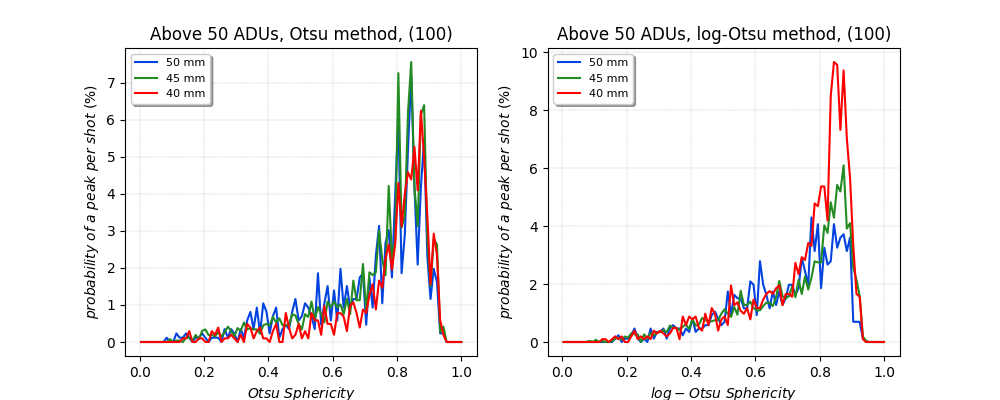

In [913]:
# sphericity Otsu vs log for all q_cm range whole dic 
fig = plt.figure(figsize = [10,4])
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # left side
binwidth = 0.001
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(dict_all_w_s_ots_100, bins=binedges)
yhist_m, bin_edges_m = np.histogram(dict_all_m_s_ots_100, bins=binedges)
yhist_c, bin_edges_c = np.histogram(dict_all_c_s_ots_100, bins=binedges)

yhist_w_log, bin_edges_w_log = np.histogram(list(filter(None, dict_all_w_s_log_100)), bins=binedges)
yhist_m_log, bin_edges_m_log = np.histogram(list(filter(None, dict_all_m_s_log_100)), bins=binedges)
yhist_c_log, bin_edges_c_log = np.histogram(list(filter(None, dict_all_c_s_log_100)), bins=binedges)

bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])

bin_centers1_log = np.array([(bin_edges_w_log[i] + bin_edges_w_log[i+1])/2 for i in range(len(bin_edges_w_log)-1)])
bin_centers2_log = np.array([(bin_edges_m_log[i] + bin_edges_m_log[i+1])/2 for i in range(len(bin_edges_m_log)-1)])
bin_centers3_log = np.array([(bin_edges_c_log[i] + bin_edges_c_log[i+1])/2 for i in range(len(bin_edges_c_log)-1)])

new_bins, new_s_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_s_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_s_c = downsample(bin_centers3, yhist_c, size=10)

new_bins_log, new_s_w_log = downsample(bin_centers1_log, yhist_w_log, size=10)
new_bins_log, new_s_m_log = downsample(bin_centers2_log, yhist_m_log, size=10)
new_bins_log, new_s_c_log = downsample(bin_centers3_log, yhist_c_log, size=10)

T_227, = ax1.plot(new_bins, (new_s_c/pershot_dict_all_c_100.sum())*100, color='#0343DF')
T_228, = ax1.plot(new_bins, (new_s_m/pershot_dict_all_m_100.sum())*100, color='forestgreen')
T_229, = ax1.plot(new_bins, (new_s_w/pershot_dict_all_w_100.sum())*100, color='r')

T_227_1, = ax2.plot(new_bins, (new_s_c_log/pershot_dict_all_c_100.sum())*100, color='#0343DF')
T_228_1, = ax2.plot(new_bins, (new_s_m_log/pershot_dict_all_m_100.sum())*100, color='forestgreen')
T_229_1, = ax2.plot(new_bins, (new_s_w_log/pershot_dict_all_w_100.sum())*100, color='r')


ax1.legend(handles=[T_227, T_228, T_229], labels=['50 mm', '45 mm', '40 mm'], loc='upper left', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax1.set_xlabel('$Otsu\ Sphericity$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax1.set_ylabel('$probability\ of\ a\ peak\ per\ shot\ (\%)$')
#plt.xlim(0.65, 1.)
ax1.set_title('Above 50 ADUs, Otsu method, (100)')
ax1.grid(c = 'grey',linestyle=':', linewidth=0.3)

ax2.legend(handles=[T_227_1, T_228_1, T_229_1], labels=['50 mm', '45 mm', '40 mm'], loc='upper left', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax2.set_xlabel('$log-Otsu\ Sphericity$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax2.set_ylabel('$probability\ of\ a\ peak\ per\ shot\ (\%)$')
#plt.xlim(0.65, 1.)
ax2.set_title('Above 50 ADUs, log-Otsu method, (100)')
ax2.grid(c = 'grey',linestyle=':', linewidth=0.3)

plt.savefig('/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/LCLS_plots/case1_101.eps', format='eps')
plt.show()  

<IPython.core.display.Javascript object>


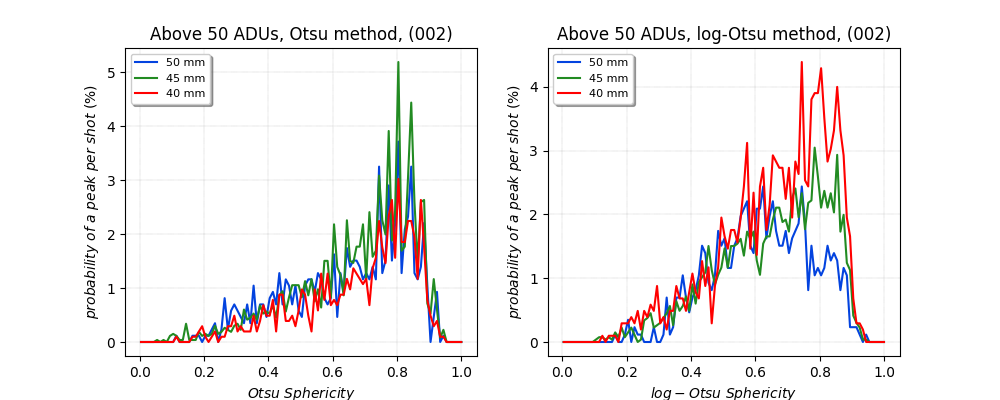

In [914]:
# sphericity Otsu vs log for all q_cm range whole dic 
fig = plt.figure(figsize = [10,4])
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # left side
binwidth = 0.001
binedges = np.arange(0-binwidth/2,1.0+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(dict_all_w_s_ots_002, bins=binedges)
yhist_m, bin_edges_m = np.histogram(dict_all_m_s_ots_002, bins=binedges)
yhist_c, bin_edges_c = np.histogram(dict_all_c_s_ots_002, bins=binedges)

yhist_w_log, bin_edges_w_log = np.histogram(list(filter(None, dict_all_w_s_log_002)), bins=binedges)
yhist_m_log, bin_edges_m_log = np.histogram(list(filter(None, dict_all_m_s_log_002)), bins=binedges)
yhist_c_log, bin_edges_c_log = np.histogram(list(filter(None, dict_all_c_s_log_002)), bins=binedges)

bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])

bin_centers1_log = np.array([(bin_edges_w_log[i] + bin_edges_w_log[i+1])/2 for i in range(len(bin_edges_w_log)-1)])
bin_centers2_log = np.array([(bin_edges_m_log[i] + bin_edges_m_log[i+1])/2 for i in range(len(bin_edges_m_log)-1)])
bin_centers3_log = np.array([(bin_edges_c_log[i] + bin_edges_c_log[i+1])/2 for i in range(len(bin_edges_c_log)-1)])

new_bins, new_s_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_s_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_s_c = downsample(bin_centers3, yhist_c, size=10)

new_bins_log, new_s_w_log = downsample(bin_centers1_log, yhist_w_log, size=10)
new_bins_log, new_s_m_log = downsample(bin_centers2_log, yhist_m_log, size=10)
new_bins_log, new_s_c_log = downsample(bin_centers3_log, yhist_c_log, size=10)

T_227, = ax1.plot(new_bins, (new_s_c/pershot_dict_all_c_002.sum())*100, color='#0343DF')
T_228, = ax1.plot(new_bins, (new_s_m/pershot_dict_all_m_002.sum())*100, color='forestgreen')
T_229, = ax1.plot(new_bins, (new_s_w/pershot_dict_all_w_002.sum())*100, color='r')

T_227_1, = ax2.plot(new_bins, (new_s_c_log/pershot_dict_all_c_002.sum())*100, color='#0343DF')
T_228_1, = ax2.plot(new_bins, (new_s_m_log/pershot_dict_all_m_002.sum())*100, color='forestgreen')
T_229_1, = ax2.plot(new_bins, (new_s_w_log/pershot_dict_all_w_002.sum())*100, color='r')


ax1.legend(handles=[T_227, T_228, T_229], labels=['50 mm', '45 mm', '40 mm'], loc='upper left', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax1.set_xlabel('$Otsu\ Sphericity$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax1.set_ylabel('$probability\ of\ a\ peak\ per\ shot\ (\%)$')
#plt.xlim(0.65, 1.)
ax1.set_title('Above 50 ADUs, Otsu method, (002)')
ax1.grid(c = 'grey',linestyle=':', linewidth=0.3)

ax2.legend(handles=[T_227_1, T_228_1, T_229_1], labels=['50 mm', '45 mm', '40 mm'], loc='upper left', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax2.set_xlabel('$log-Otsu\ Sphericity$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax2.set_ylabel('$probability\ of\ a\ peak\ per\ shot\ (\%)$')
#plt.xlim(0.65, 1.)
ax2.set_title('Above 50 ADUs, log-Otsu method, (002)')
ax2.grid(c = 'grey',linestyle=':', linewidth=0.3)

plt.savefig('/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/LCLS_plots/case1_101.eps', format='eps')
plt.show()  

<IPython.core.display.Javascript object>


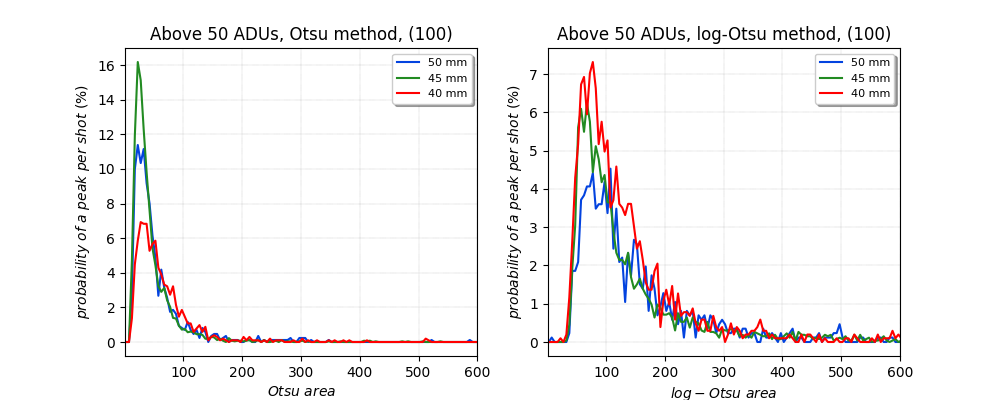

In [908]:
# area Otsu vs log for all q_cm range whole dic 
fig = plt.figure(figsize = [10,4])
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # left side
binwidth = 0.5
binedges = np.arange(0-binwidth/2,800+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(dict_all_w_a_ots_100, bins=binedges)
yhist_m, bin_edges_m = np.histogram(dict_all_m_a_ots_100, bins=binedges)
yhist_c, bin_edges_c = np.histogram(dict_all_c_a_ots_100, bins=binedges)

yhist_w_log, bin_edges_w_log = np.histogram(list(filter(None, dict_all_w_a_log_100)), bins=binedges)
yhist_m_log, bin_edges_m_log = np.histogram(list(filter(None, dict_all_m_a_log_100)), bins=binedges)
yhist_c_log, bin_edges_c_log = np.histogram(list(filter(None, dict_all_c_a_log_100)), bins=binedges)

bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])

bin_centers1_log = np.array([(bin_edges_w_log[i] + bin_edges_w_log[i+1])/2 for i in range(len(bin_edges_w_log)-1)])
bin_centers2_log = np.array([(bin_edges_m_log[i] + bin_edges_m_log[i+1])/2 for i in range(len(bin_edges_m_log)-1)])
bin_centers3_log = np.array([(bin_edges_c_log[i] + bin_edges_c_log[i+1])/2 for i in range(len(bin_edges_c_log)-1)])

new_bins, new_a_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_a_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_a_c = downsample(bin_centers3, yhist_c, size=10)

new_bins_log, new_a_w_log = downsample(bin_centers1_log, yhist_w_log, size=10)
new_bins_log, new_a_m_log = downsample(bin_centers2_log, yhist_m_log, size=10)
new_bins_log, new_a_c_log = downsample(bin_centers3_log, yhist_c_log, size=10)

T_227, = ax1.plot(new_bins, (new_a_c/pershot_dict_all_c_100.sum())*100, color='#0343DF')
T_228, = ax1.plot(new_bins, (new_a_m/pershot_dict_all_m_100.sum())*100, color='forestgreen')
T_229, = ax1.plot(new_bins, (new_a_w/pershot_dict_all_w_100.sum())*100, color='r')

T_227_1, = ax2.plot(new_bins, (new_a_c_log/pershot_dict_all_c_100.sum())*100, color='#0343DF')
T_228_1, = ax2.plot(new_bins, (new_a_m_log/pershot_dict_all_m_100.sum())*100, color='forestgreen')
T_229_1, = ax2.plot(new_bins, (new_a_w_log/pershot_dict_all_w_100.sum())*100, color='r')



ax1.legend(handles=[T_227, T_228, T_229], labels=['50 mm', '45 mm', '40 mm'], loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax1.set_xlabel('$Otsu\ area$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax1.set_ylabel('$probability\ of\ a\ peak\ per\ shot\ (\%)$')
#plt.xlim(0.65, 1.)
ax1.set_title('Above 50 ADUs, Otsu method, (100)')
ax1.grid(c = 'grey',linestyle=':', linewidth=0.3)

ax2.legend(handles=[T_227_1, T_228_1, T_229_1], labels=['50 mm', '45 mm', '40 mm'], loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax2.set_xlabel('$log-Otsu\ area$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax2.set_ylabel('$probability\ of\ a\ peak\ per\ shot\ (\%)$')
ax1.set_xlim(0.5, 600)
ax2.set_xlim(0.5, 600)
ax2.set_title('Above 50 ADUs, log-Otsu method, (100)')
ax2.grid(c = 'grey',linestyle=':', linewidth=0.3)

plt.savefig('/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/LCLS_plots/case1_101.eps', format='eps')
plt.show()  

<IPython.core.display.Javascript object>


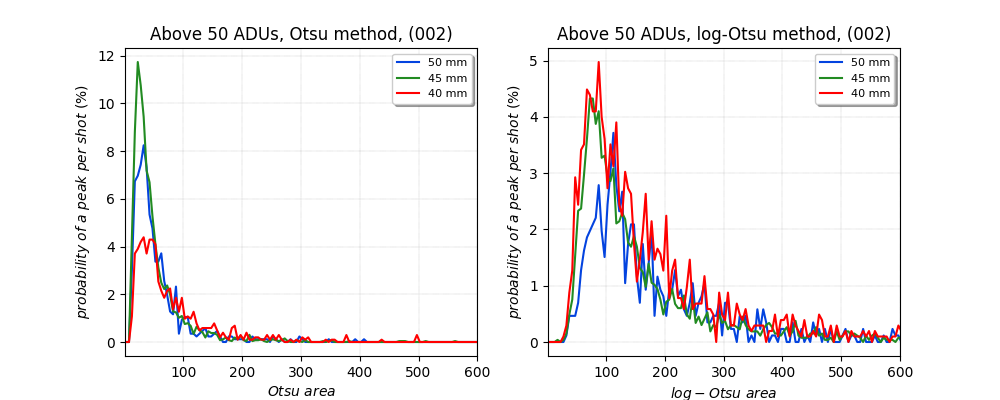

In [911]:
# area Otsu vs log for all q_cm range whole dic 
fig = plt.figure(figsize = [10,4])
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # left side
binwidth = 0.5
binedges = np.arange(0-binwidth/2,800+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(dict_all_w_a_ots_002, bins=binedges)
yhist_m, bin_edges_m = np.histogram(dict_all_m_a_ots_002, bins=binedges)
yhist_c, bin_edges_c = np.histogram(dict_all_c_a_ots_002, bins=binedges)

yhist_w_log, bin_edges_w_log = np.histogram(list(filter(None, dict_all_w_a_log_002)), bins=binedges)
yhist_m_log, bin_edges_m_log = np.histogram(list(filter(None, dict_all_m_a_log_002)), bins=binedges)
yhist_c_log, bin_edges_c_log = np.histogram(list(filter(None, dict_all_c_a_log_002)), bins=binedges)

bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])

bin_centers1_log = np.array([(bin_edges_w_log[i] + bin_edges_w_log[i+1])/2 for i in range(len(bin_edges_w_log)-1)])
bin_centers2_log = np.array([(bin_edges_m_log[i] + bin_edges_m_log[i+1])/2 for i in range(len(bin_edges_m_log)-1)])
bin_centers3_log = np.array([(bin_edges_c_log[i] + bin_edges_c_log[i+1])/2 for i in range(len(bin_edges_c_log)-1)])

new_bins, new_a_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_a_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_a_c = downsample(bin_centers3, yhist_c, size=10)

new_bins_log, new_a_w_log = downsample(bin_centers1_log, yhist_w_log, size=10)
new_bins_log, new_a_m_log = downsample(bin_centers2_log, yhist_m_log, size=10)
new_bins_log, new_a_c_log = downsample(bin_centers3_log, yhist_c_log, size=10)

T_227, = ax1.plot(new_bins, (new_a_c/pershot_dict_all_c_002.sum())*100, color='#0343DF')
T_228, = ax1.plot(new_bins, (new_a_m/pershot_dict_all_m_002.sum())*100, color='forestgreen')
T_229, = ax1.plot(new_bins, (new_a_w/pershot_dict_all_w_002.sum())*100, color='r')

T_227_1, = ax2.plot(new_bins, (new_a_c_log/pershot_dict_all_c_002.sum())*100, color='#0343DF')
T_228_1, = ax2.plot(new_bins, (new_a_m_log/pershot_dict_all_m_002.sum())*100, color='forestgreen')
T_229_1, = ax2.plot(new_bins, (new_a_w_log/pershot_dict_all_w_002.sum())*100, color='r')



ax1.legend(handles=[T_227, T_228, T_229], labels=['50 mm', '45 mm', '40 mm'], loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax1.set_xlabel('$Otsu\ area$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax1.set_ylabel('$probability\ of\ a\ peak\ per\ shot\ (\%)$')
#plt.xlim(0.65, 1.)
ax1.set_title('Above 50 ADUs, Otsu method, (002)')
ax1.grid(c = 'grey',linestyle=':', linewidth=0.3)

ax2.legend(handles=[T_227_1, T_228_1, T_229_1], labels=['50 mm', '45 mm', '40 mm'], loc='upper right', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax2.set_xlabel('$log-Otsu\ area$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax2.set_ylabel('$probability\ of\ a\ peak\ per\ shot\ (\%)$')
ax1.set_xlim(0.5, 600)
ax2.set_xlim(0.5, 600)
ax2.set_title('Above 50 ADUs, log-Otsu method, (002)')
ax2.grid(c = 'grey',linestyle=':', linewidth=0.3)

plt.savefig('/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/LCLS_plots/case1_101.eps', format='eps')
plt.show()  

<IPython.core.display.Javascript object>


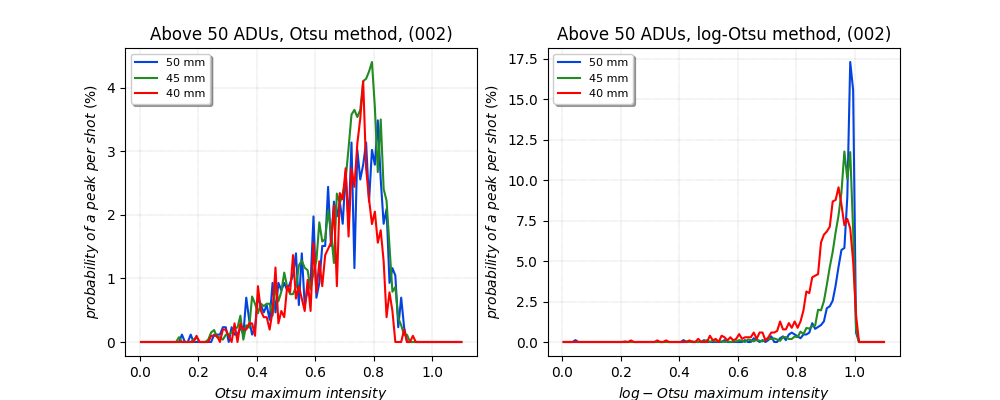

In [916]:
# max I with Otsu vs log for all q_cm range whole dic 
fig = plt.figure(figsize = [10,4])
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # left side
binwidth = 0.001
binedges = np.arange(0-binwidth/2,1.1+3*binwidth/2,binwidth)
yhist_w, bin_edges_w = np.histogram(dict_all_w_i_ots_002, bins=binedges)
yhist_m, bin_edges_m = np.histogram(dict_all_m_i_ots_002, bins=binedges)
yhist_c, bin_edges_c = np.histogram(dict_all_c_i_ots_002, bins=binedges)

yhist_w_log, bin_edges_w_log = np.histogram(list(filter(None, dict_all_w_i_log_002)), bins=binedges)
yhist_m_log, bin_edges_m_log = np.histogram(list(filter(None, dict_all_m_i_log_002)), bins=binedges)
yhist_c_log, bin_edges_c_log = np.histogram(list(filter(None, dict_all_c_i_log_002)), bins=binedges)

bin_centers1 = np.array([(bin_edges_w[i] + bin_edges_w[i+1])/2 for i in range(len(bin_edges_w)-1)])
bin_centers2 = np.array([(bin_edges_m[i] + bin_edges_m[i+1])/2 for i in range(len(bin_edges_m)-1)])
bin_centers3 = np.array([(bin_edges_c[i] + bin_edges_c[i+1])/2 for i in range(len(bin_edges_c)-1)])

bin_centers1_log = np.array([(bin_edges_w_log[i] + bin_edges_w_log[i+1])/2 for i in range(len(bin_edges_w_log)-1)])
bin_centers2_log = np.array([(bin_edges_m_log[i] + bin_edges_m_log[i+1])/2 for i in range(len(bin_edges_m_log)-1)])
bin_centers3_log = np.array([(bin_edges_c_log[i] + bin_edges_c_log[i+1])/2 for i in range(len(bin_edges_c_log)-1)])

new_bins, new_i_w = downsample(bin_centers1, yhist_w, size=10)
new_bins, new_i_m = downsample(bin_centers2, yhist_m, size=10)
new_bins, new_i_c = downsample(bin_centers3, yhist_c, size=10)

new_bins_log, new_i_w_log = downsample(bin_centers1_log, yhist_w_log, size=10)
new_bins_log, new_i_m_log = downsample(bin_centers2_log, yhist_m_log, size=10)
new_bins_log, new_i_c_log = downsample(bin_centers3_log, yhist_c_log, size=10)

T_227, = ax1.plot(new_bins, (new_i_c/pershot_dict_all_c_002.sum())*100, color='#0343DF')
T_228, = ax1.plot(new_bins, (new_i_m/pershot_dict_all_m_002.sum())*100, color='forestgreen')
T_229, = ax1.plot(new_bins, (new_i_w/pershot_dict_all_w_002.sum())*100, color='r')

T_227_1, = ax2.plot(new_bins, (new_i_c_log/pershot_dict_all_c_002.sum())*100, color='#0343DF')
T_228_1, = ax2.plot(new_bins, (new_i_m_log/pershot_dict_all_m_002.sum())*100, color='forestgreen')
T_229_1, = ax2.plot(new_bins, (new_i_w_log/pershot_dict_all_w_002.sum())*100, color='r')



ax1.legend(handles=[T_227, T_228, T_229], labels=['50 mm', '45 mm', '40 mm'], loc='upper left', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax1.set_xlabel('$Otsu\ maximum\ intensity$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax1.set_ylabel('$probability\ of\ a\ peak\ per\ shot\ (\%)$')
#plt.xlim(0.65, 1.)
ax1.set_title('Above 50 ADUs, Otsu method, (002)')
ax1.grid(c = 'grey',linestyle=':', linewidth=0.3)

ax2.legend(handles=[T_227_1, T_228_1, T_229_1], labels=['50 mm', '45 mm', '40 mm'], loc='upper left', prop={'size': 8}, fancybox=True, framealpha=1, shadow=True, borderpad=0.4)
ax2.set_xlabel('$log-Otsu\ maximum\ intensity$')
#plt.ylabel('$fraction$ $of$ $peaks\ (\%)$')
#plt.ylabel('$Number$ $of$ $peaks$')
ax2.set_ylabel('$probability\ of\ a\ peak\ per\ shot\ (\%)$')
#ax1.set_xlim(0.5, 600)
#ax2.set_xlim(0.5, 600)
ax2.set_title('Above 50 ADUs, log-Otsu method, (002)')
ax2.grid(c = 'grey',linestyle=':', linewidth=0.3)

plt.savefig('/Users/niloo/Desktop/LCLS/14Dec2020/LCLS_files/LCLS_plots/case1_101.eps', format='eps')
plt.show()  

In [ ]:
# class 3 multiple peaks in 1 cutout 
# class 4 single maxima and PCF<0.2 